In [1]:
# Basic
import numpy as np
import pandas as pd

# Dates
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta

import warnings

# Formatting
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')

In [2]:
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import optuna

from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight
from scipy.stats import ks_2samp

from lightgbm import LGBMClassifier

from optbinning import OptimalBinning
from optbinning.scorecard import plot_auc_roc, plot_ks

import shap

(CVXPY) Sep 30 07:28:12 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.7.2996). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Sep 30 07:28:12 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.7.2996). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


## Funções

In [4]:
def find_outliers_IQR(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    IQR = q3 - q1
    return df[((df < (q1 - 1.5*IQR)) | (df > (q3 + 1.5*IQR)))]


In [5]:
def remove_feats_by_freq(df, features, threshold=0.8):
    feats = features.copy()
    removed_feats = []
    contador = 0
    for col in df[feats].columns:
        freq = df[col].value_counts(normalize=True)
        
        if freq.max() >= threshold:
            contador +=1
            feats.remove(col)
            removed_feats.append(col)
    
    print('=' * 50)
    print('Interation:', contador)
    print('Features:', len(feats))
    print('=' * 50)
    return feats, removed_feats

In [6]:
import bisect

def determine_grade(scores, breakpoints=[], grades=[]):
    i = bisect.bisect_left(breakpoints, scores)
    return grades[i]

def binning(dataframe, feature, bins='decil', return_all=False):
    dataframe = dataframe.copy()
    bins_options = {
        'quartil': [25, 50, 75],
        'quintil': [20, 40, 60, 80],
        'decil': list(range(10, 100, 10)),
        'vintil': list(range(5, 100, 5)),
    }

    # missing values
    dataframe[feature].fillna(-1, inplace=True)
    breakpoints = [-0.5]
    breakpoints.extend([np.percentile(
        dataframe.loc[dataframe[feature].notnull(), feature], p) for p in bins_options[bins]])

    grades = []
    for idx in range(len(breakpoints) + 1):
        if idx == 0:
            grades.append(str(idx + 1).zfill(2) + '. ' + 'missing')
        elif idx == 1:
            grades.append(str(idx + 1).zfill(2) + '. ' +
                          '[ min ; ' + str(int(breakpoints[idx])) + ' ]')
        elif idx == (len(breakpoints)):
            grades.append(str(idx + 1).zfill(2) + '. ' +
                          '( ' + str(int(breakpoints[idx-1])) + ' ; max ]')
        else:
            grades.append(str(idx + 1).zfill(2) + '. ' + '( ' +
                          str(int(breakpoints[idx-1])) + ' ; ' + str(int(breakpoints[idx])) + ' ]')

    dataframe.loc[:, feature + '_bin'] = [
        determine_grade(s, breakpoints, grades) for s in dataframe.loc[:, feature]
    ]
    
    if return_all==True:
        return dataframe, breakpoints, grades
    else:
        return dataframe


In [7]:
def plot_bads(y_true, score, title=''):
    score_validation = pd.DataFrame({'y_score': score, 'y_test': y_true})
    score_validation = binning(score_validation, 'y_score', bins='decil')

    agg = score_validation.groupby(['y_score_bin'])['y_test'].agg(
        ['count', 'mean']).reset_index().sort_values(by='y_score_bin', ascending=False)

    agg['cum_sum'] = agg['mean'].cumsum()
    agg['factor'] = list(range(1, 11))
    agg['cum_mean'] = agg['cum_sum'] / agg['factor']

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=agg['y_score_bin'],
        y=agg['cum_mean'],
        mode="lines+markers",
        name='Média acumulada'
    ))
    
    fig.add_trace(go.Scatter(
        x=agg['y_score_bin'],
        y=agg['mean'],
        mode="lines+markers",
        name='Média do bin'
    ))

    fig.update_xaxes(categoryorder='category ascending')

    fig.update_layout(
        title_text=title,
        title_font_family="Arial",
        title_font_size=28,
        title_x=0.5,
        xaxis_showgrid=True,
        yaxis_showgrid=True,
        yaxis={"title": "% Default", "range": [
            agg['mean'].min() - 0.05, agg['mean'].max() + 0.05]},
    )

    fig.show()

In [8]:
def ks_roc_safra(df, coluna, indicador, score):
    ks = []
    auc = []

    safras = df[coluna].unique().tolist()
    safras.sort()

    for safra in safras:
        ks.append(ks_2samp(df.loc[(df[coluna] == safra) & (df[indicador] == 0), score],
                       df.loc[(df[coluna] == safra) & (df[indicador] == 1), score], mode='exact')[0])
        auc.append(roc_auc_score(df.loc[(df[coluna] == safra), indicador],
                       1000 - df.loc[(df[coluna] == safra), score]))
    
    Grafic = pd.DataFrame({coluna: safras, 'KS': ks, 'AUC': auc})
    Grafic['KS'] = round(Grafic['KS'] * 100, 1)
    Grafic['AUC'] = round(Grafic['AUC'] * 100, 1)
    
    return Grafic


def plot_ks_roc(df, coluna, indicador, score):
    Grafic = ks_roc_safra(df, coluna=coluna, indicador=indicador, score=score)

    plt.figure(figsize=(13, 5))

    plt.plot(Grafic['safra'], Grafic['KS'],
             linewidth='3',
             marker='o'
             )

    plt.plot(Grafic['safra'], Grafic['AUC'],
             linewidth='3',
             marker='o'
             )
    plt.title("AUC e KS por Safra")
    min_ = ((Grafic['KS'].min() // 5) - 1) * 5
    max_ = ((Grafic['AUC'].max() // 5) + 2) * 5
    plt.ylim(min_, max_)

    plt.yticks(np.arange(min_, max_, 5, dtype=int))

    plt.grid(color='lightgray')
    plt.legend(['KS', 'AUC'])

    for (i, valor) in enumerate(Grafic['KS'], start=0):
        plt.text(x=Grafic['safra'][i],
                 y=valor + 1,
                 s=f'{valor}')

    for (i, valor) in enumerate(Grafic['AUC'], start=0):
        plt.text(x=Grafic['safra'][i],
                 y=valor + 1,
                 s=f'{valor}')

## Abertura arquivo

In [9]:
df = pd.read_excel('./Esutdo_Caso_DS.xlsx', sheet_name="Base_Dados", dtype={'safra': str})
print(df.shape)
df.sample(5)

(32842, 18)


,safra,id_trx,Data compra,Hora da compra,Tipo de cliente,valor_compra,Tempo até utilização,over30_mob3,risco_validador,provedor_email,idade_cliente,Produto_1,Produto_2,Produto_3,uf,Renda,Score Email,Score Pessoa
29794,202212,9194,2022-12-15,23,3,4463.0000,31 - 45 dias,0,Baixo Risco,gmail,40.0000,1,1,0,PA,3550.0000,3.0000,504.0000
6386,202303,9868,2023-03-27,20,1,5513.0000,61 - 90 dias,0,Baixo Risco,gmail,25.0000,1,0,0,BA,1200.0000,83.0000,340.0000
18716,202302,28801,2023-02-02,14,1,2926.4800,181 - 210 dias,1,Baixo Risco,yahoo,52.0000,1,1,0,SP,11050.0000,43.0000,256.0000
10124,202303,15589,2023-03-04,22,1,2621.6800,211 - 240 dias,1,Baixo Risco,outlook,29.0000,1,1,0,SP,4950.0000,193.0000,347.0000
1561,202211,2463,2022-11-16,12,1,1277.5000,31 - 45 dias,0,Baixo Risco,yahoo,22.0000,1,0,0,SP,1150.0000,11.0000,213.0000


In [10]:
target = 'over30_mob3'

### Análise exploratória

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32842 entries, 0 to 32841
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   safra                 32842 non-null  object        
 1   id_trx                32842 non-null  int64         
 2   Data compra           32842 non-null  datetime64[ns]
 3   Hora da compra        32842 non-null  int64         
 4   Tipo de cliente       32842 non-null  int64         
 5   valor_compra          32842 non-null  float64       
 6   Tempo até utilização  32842 non-null  object        
 7   over30_mob3           32842 non-null  int64         
 8   risco_validador       32842 non-null  object        
 9   provedor_email        32665 non-null  object        
 10  idade_cliente         32797 non-null  float64       
 11  Produto_1             32842 non-null  int64         
 12  Produto_2             32842 non-null  int64         
 13  Produto_3       

In [12]:
df.describe()

,id_trx,Hora da compra,Tipo de cliente,valor_compra,over30_mob3,idade_cliente,Produto_1,Produto_2,Produto_3,Renda,Score Email,Score Pessoa
count,32842.0000,32842.0000,32842.0000,32842.0000,32842.0000,32797.0000,32842.0000,32842.0000,32842.0000,32673.0000,30501.0000,32759.0000
mean,16421.5000,14.6708,1.8718,3084.3784,0.1265,35.1197,0.9376,0.3232,0.0769,7314.3176,110.9277,456.8031
std,9480.8131,5.7138,1.2876,3592.5919,0.3324,12.0852,0.2419,0.4677,0.2665,13559.2993,146.3382,127.1866
min,1.0000,0.0000,1.0000,69.0100,0.0000,18.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
25%,8211.2500,11.0000,1.0000,1045.2025,0.0000,23.0000,1.0000,0.0000,0.0000,2050.0000,50.0000,367.0000
50%,16421.5000,15.0000,1.0000,2021.2700,0.0000,33.0000,1.0000,0.0000,0.0000,4250.0000,82.0000,458.0000
75%,24631.7500,19.0000,4.0000,3914.1825,0.0000,44.0000,1.0000,1.0000,0.0000,6450.0000,121.0000,550.0000
max,32842.0000,23.0000,4.0000,112101.7500,1.0000,88.0000,1.0000,1.0000,1.0000,360000.0000,995.0000,919.0000


In [13]:
df.isnull().sum()

safra                      0
id_trx                     0
Data compra                0
Hora da compra             0
Tipo de cliente            0
valor_compra               0
Tempo até utilização       0
over30_mob3                0
risco_validador            0
provedor_email           177
idade_cliente             45
Produto_1                  0
Produto_2                  0
Produto_3                  0
uf                       177
Renda                    169
Score Email             2341
Score Pessoa              83
dtype: int64

In [14]:
df.isnull().sum() / df.count()

safra                  0.0000
id_trx                 0.0000
Data compra            0.0000
Hora da compra         0.0000
Tipo de cliente        0.0000
valor_compra           0.0000
Tempo até utilização   0.0000
over30_mob3            0.0000
risco_validador        0.0000
provedor_email         0.0054
idade_cliente          0.0014
Produto_1              0.0000
Produto_2              0.0000
Produto_3              0.0000
uf                     0.0054
Renda                  0.0052
Score Email            0.0768
Score Pessoa           0.0025
dtype: float64

In [15]:
print('Linhas com algum dado faltante:', df.shape[0] - df.dropna().shape[0])
print('Percentual do dataset:', ((df.shape[0] - df.dropna().shape[0]) / len(df)) * 100)

Linhas com algum dado faltante: 2597
Percentual do dataset: 7.907557396017295


In [16]:
df.groupby('safra')[['valor_compra', 'over30_mob3', 'Renda', 'Score Email', 'Score Pessoa']].agg(['count', 'mean'])

valor_compra           over30_mob3        Renda           Score Email  \
              count      mean       count   mean count      mean       count   
safra                                                                          
202211         6319 3349.9487        6319 0.0810  6226 7927.6743        6211   
202212         6772 2892.4929        6772 0.1118  6697 7548.3052        4562   
202301         7444 3012.1055        7444 0.1424  7444 6642.9876        7441   
202302         5376 3090.6975        5376 0.1600  5375 6870.1302        5373   
202303         6931 3102.4620        6931 0.1394  6931 7602.7485        6914   

                Score Pessoa           
           mean        count     mean  
safra                                  
202211  98.8018         6236 468.9506  
202212  99.6381         6772 478.1307  
202301 115.0439         7444 445.4933  
202302 113.5837         5376 443.2333  
202303 122.7758         6931 447.7078

<Axes: xlabel='Data compra', ylabel='Count'>

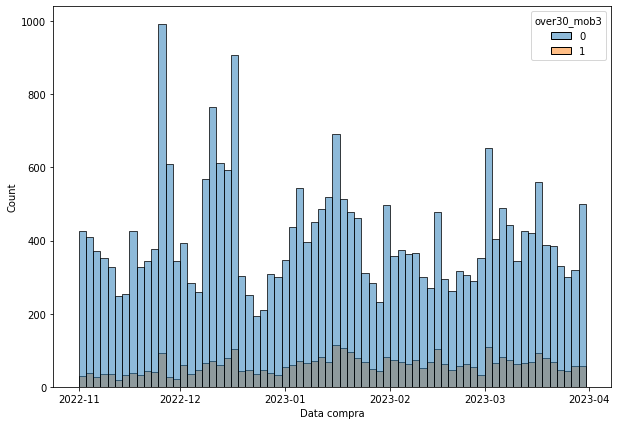

In [17]:
fig = plt.figure(figsize=(10, 7))
sns.histplot(df, x='Data compra', bins=70, hue=target)

<Axes: xlabel='Hora da compra', ylabel='Count'>

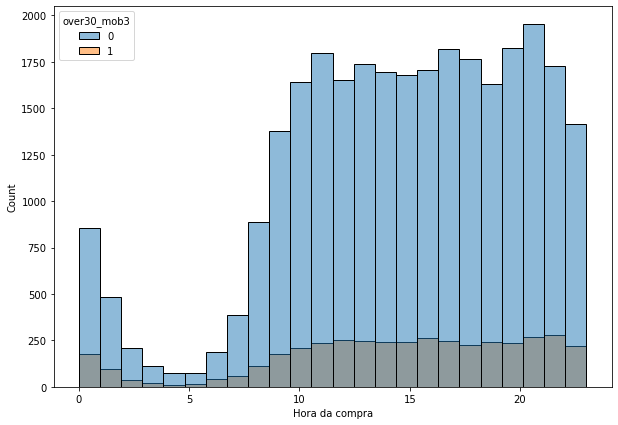

In [18]:
fig = plt.figure(figsize=(10, 7))
sns.histplot(df, x='Hora da compra', bins=24, hue=target)

<Axes: xlabel='Tipo de cliente', ylabel='count'>

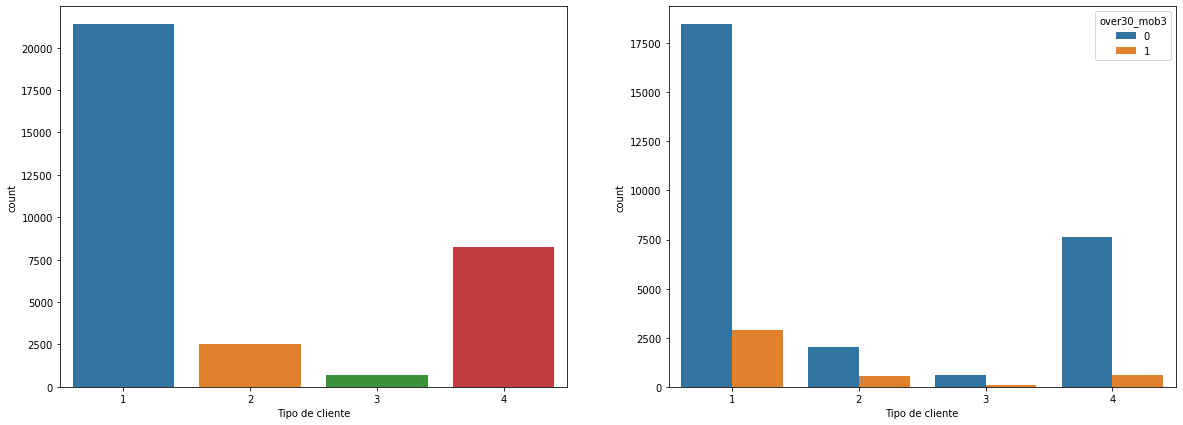

In [19]:
fig = plt.figure(figsize=(20, 7))

fig.add_subplot(121)
sns.countplot(df, x='Tipo de cliente')

fig.add_subplot(122)
sns.countplot(df, x='Tipo de cliente', hue=target)

<Axes: ylabel='valor_compra'>

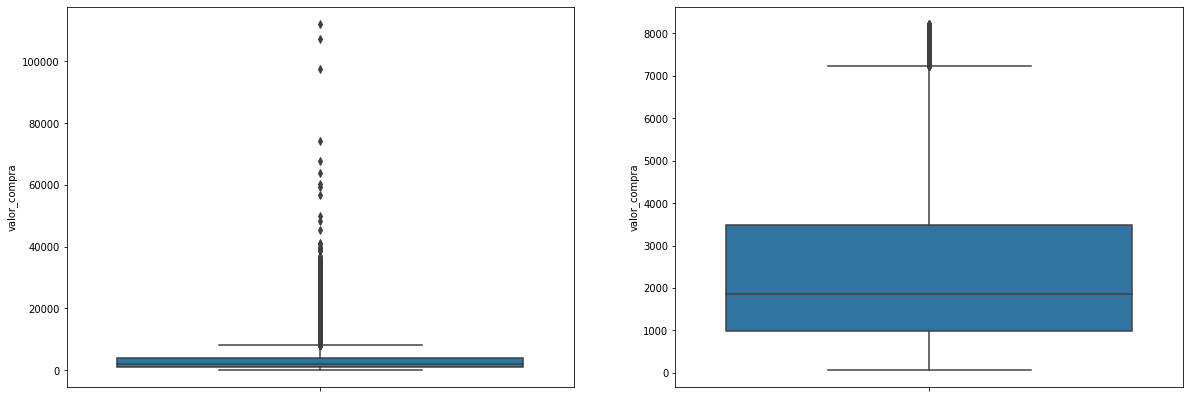

In [20]:
outliers = find_outliers_IQR(df['valor_compra'])

fig = plt.figure(figsize=(20, 7))

fig.add_subplot(121)
sns.boxplot(df, y='valor_compra')

fig.add_subplot(122)
sns.boxplot(df.loc[df['valor_compra'] <= outliers.min()], y='valor_compra')

<Axes: xlabel='Tempo até utilização', ylabel='count'>

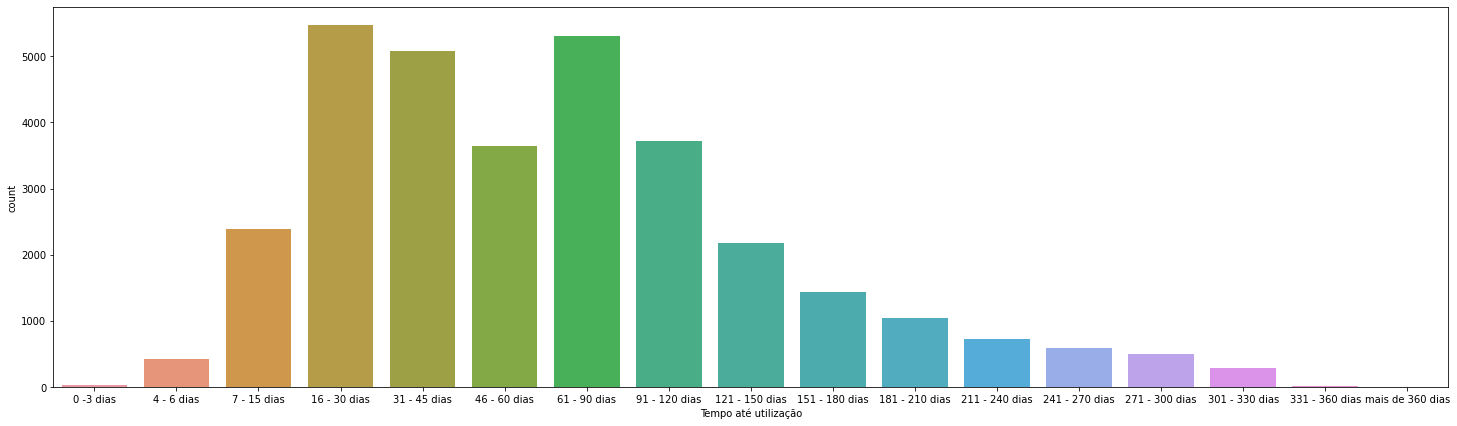

In [21]:
fig = plt.figure(figsize=(25, 7))
order_x = ['0 -3 dias', '4 - 6 dias', '7 - 15 dias', '16 - 30 dias',
           '31 - 45 dias', '46 - 60 dias', '61 - 90 dias', '91 - 120 dias',
           '121 - 150 dias', '151 - 180 dias', '181 - 210 dias', '211 - 240 dias',
           '241 - 270 dias', '271 - 300 dias', '301 - 330 dias',  '331 - 360 dias',
           'mais de 360 dias']
sns.countplot(df, x='Tempo até utilização', order=order_x)


<Axes: xlabel='risco_validador', ylabel='count'>

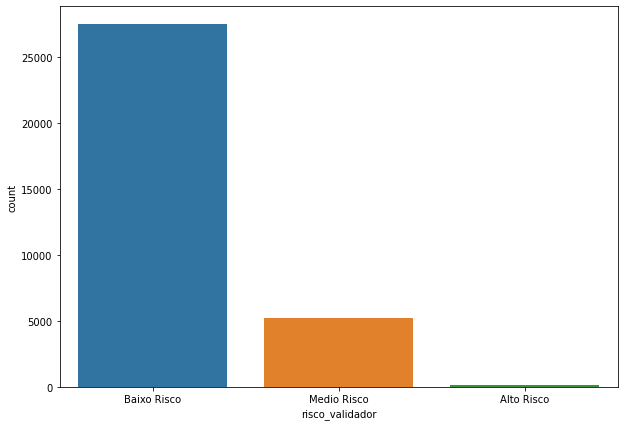

In [22]:
fig = plt.figure(figsize=(10, 7))
sns.countplot(df, x='risco_validador')

In [23]:
df['provedor_email'].value_counts()

gmail               19824
hotmail              8060
yahoo                1515
outlook               910
icloud                763
                    ...  
orys                    1
triamanorte             1
sementestropical        1
zucatelli               1
betaniacosta            1
Name: provedor_email, Length: 731, dtype: int64

<Axes: xlabel='idade_cliente', ylabel='Count'>

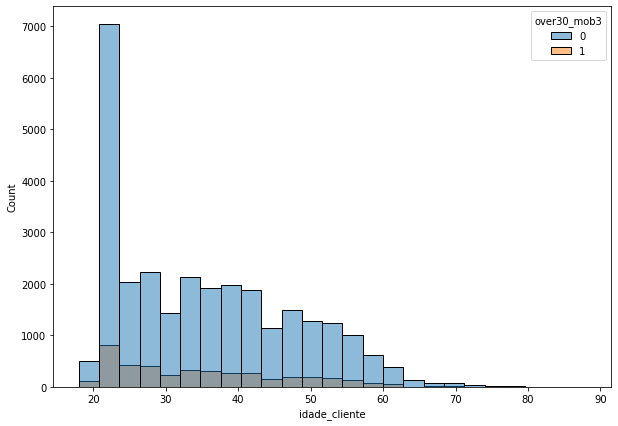

In [24]:
fig = plt.figure(figsize=(10, 7))
sns.histplot(df, x='idade_cliente', bins=25, hue=target)

<Axes: xlabel='Produto_3', ylabel='count'>

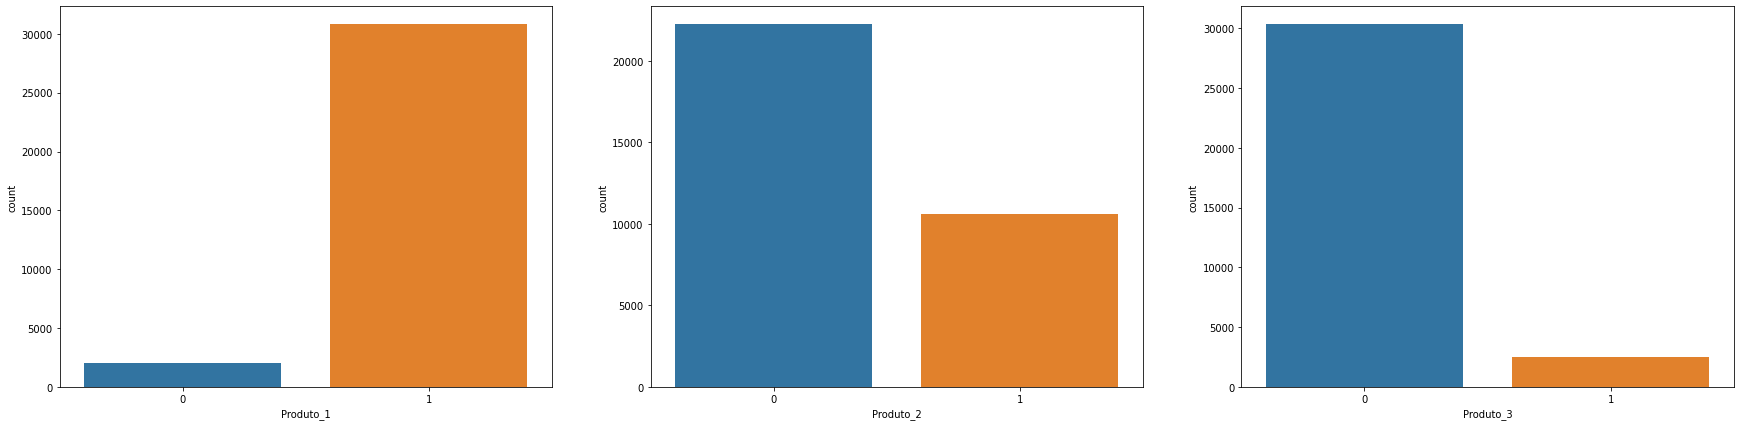

In [25]:
fig = plt.figure(figsize=(30, 7))

fig.add_subplot(131)
sns.countplot(df, x='Produto_1')

fig.add_subplot(132)
sns.countplot(df, x='Produto_2')

fig.add_subplot(133)
sns.countplot(df, x='Produto_3')

<Axes: >

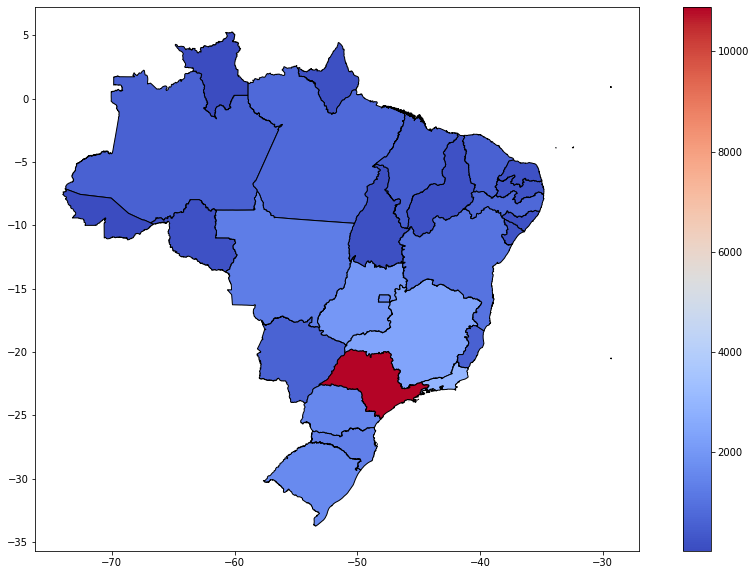

In [26]:
INFOS_UFS = gpd.read_file('bcim_2016_21_11_2018.gpkg',layer='lim_unidade_federacao_a')

brazil_plot = INFOS_UFS.merge(df.groupby('uf')['id_trx'].count().reset_index(), left_on='sigla', right_on='uf', how='left')
brazil_plot.plot(column='id_trx', cmap='coolwarm', figsize=(16, 10), legend=True, edgecolor='black')


<Axes: ylabel='Renda'>

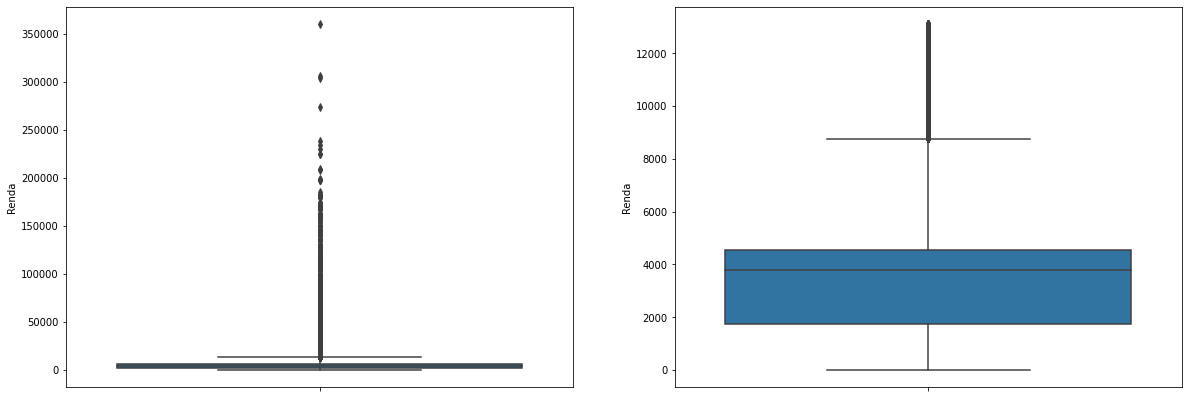

In [27]:
outliers = find_outliers_IQR(df['Renda'])

fig = plt.figure(figsize=(20, 7))

fig.add_subplot(121)
sns.boxplot(df, y='Renda')

fig.add_subplot(122)
sns.boxplot(df.loc[df['Renda'] <= outliers.min()], y='Renda')

<Axes: xlabel='Score Email', ylabel='Count'>

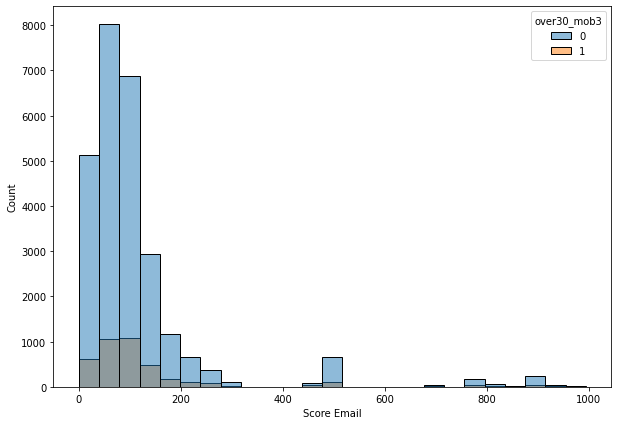

In [28]:
fig = plt.figure(figsize=(10, 7))
sns.histplot(df, x='Score Email', bins=25, hue=target)

Após plotar o histograma desse score, notei um comportamento que a princípio julguei estranho, pois o score apresenta concentrações e faixas sem praticamente nenhum valor, acredito que esse seja o resultado de algum score de fraude. Entretanto, por conta dessa característica, decidi mudar a forma de vizualização para poder ver seu comportamento.

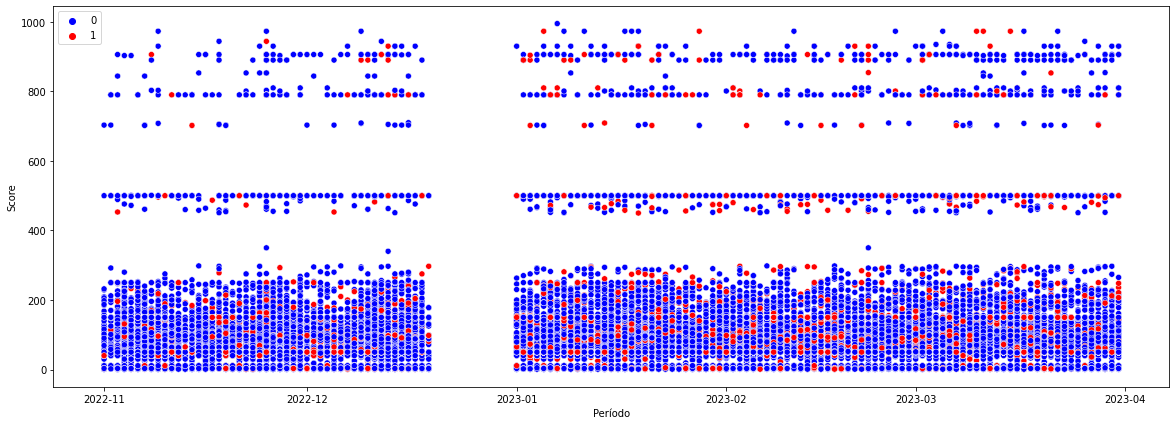

In [29]:
fig = plt.figure(figsize=(20, 7))
ax = sns.scatterplot(data=df, x="Data compra", y="Score Email", hue=target, palette=['blue', 'red'])
ax.set_xlabel('Período')
ax.set_ylabel('Score')
ax.legend(loc='upper left')

Nesse momento, percebi uma grande faixa onde o score não possui resultados, até esse momento, estava pensando em simplesmente apagar as linhas com valores nulos (pois a variável com mais nulos representa apenas 7% do dataset, e apagar todas as linhas eu estaria reduzindo o grupo de dados de 32842 para 30245), entretanto, dado o contexto onde os dados estão faltando (datas próximas ao natal), decidi que iria tratar os valores nulos de todas as variáveis

(0.0, 1000.0)

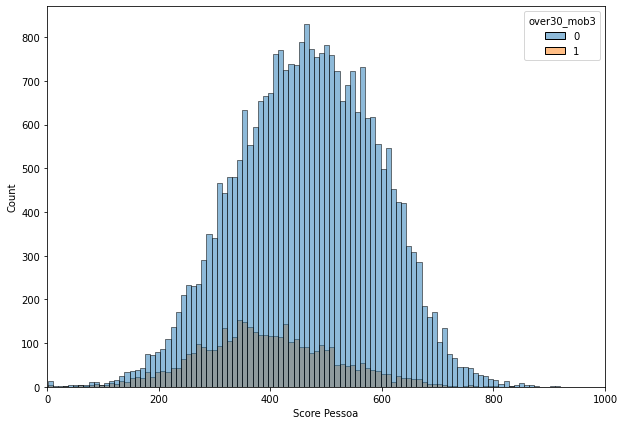

In [30]:
fig = plt.figure(figsize=(10, 7))
sns.histplot(df, x='Score Pessoa', bins=100, hue=target)
plt.xlim(0, 1000)

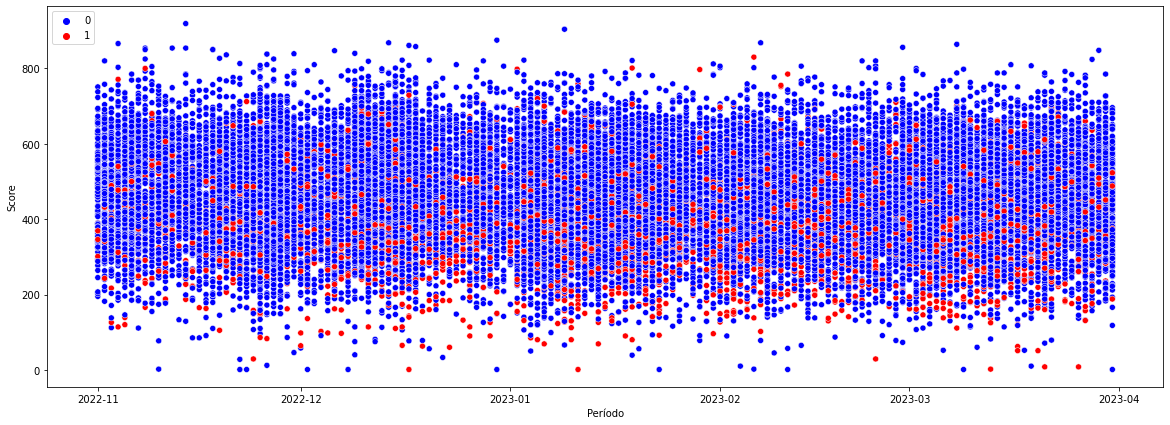

In [31]:
fig = plt.figure(figsize=(20, 7))
ax = sns.scatterplot(data=df, x="Data compra", y="Score Pessoa", hue=target, palette=['blue', 'red'])
ax.set_xlabel('Período')
ax.set_ylabel('Score')
ax.legend(loc='upper left')

O Score Pessoa parece ser um score de bureau, visto que ele já apresenta alguma ordenação dos dados, nesse sentido, decidi estudar um pouco ele para observar qual o seu poder preditivo. Partindo o princípio que esse é um score padronizado, vou assumir esse score como baseline e trabalhar para que o novo score desenvolvido seja melhor que ele.

## Análise do Score Pessoa

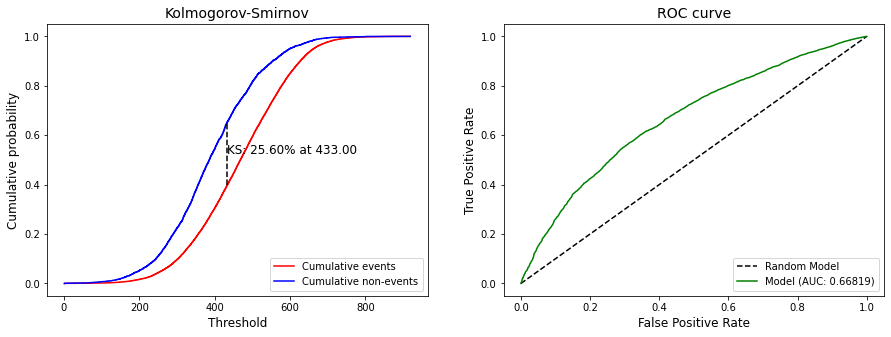

In [32]:
fig = plt.figure(figsize=(15, 5))

fig.add_subplot(121)
plot_ks(df.loc[~df['Score Pessoa'].isnull(), target] * -1 + 1, df.loc[~df['Score Pessoa'].isnull(), 'Score Pessoa'])

fig.add_subplot(122)
plot_auc_roc(df.loc[~df['Score Pessoa'].isnull(), target] * -1 + 1, df.loc[~df['Score Pessoa'].isnull(), 'Score Pessoa'])

In [33]:
optb = OptimalBinning(name='score', dtype="numerical", solver="cp")
optb.fit(df['Score Pessoa'], df[target])
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 287.50)",3066,0.0934,2257,809,0.2639,-0.9061,0.1051,0.0127
1,"[287.50, 370.50)",5404,0.1645,4337,1067,0.1974,-0.5298,0.0560,0.0069
2,"[370.50, 402.50)",2733,0.0832,2307,426,0.1559,-0.2429,0.0054,0.0007
3,"[402.50, 433.50)",2904,0.0884,2491,413,0.1422,-0.1351,0.0017,0.0002
4,"[433.50, 451.50)",1666,0.0507,1458,208,0.1248,0.0152,0.0000,0.0000
5,"[451.50, 516.50)",6049,0.1842,5442,607,0.1003,0.2612,0.0114,0.0014
6,"[516.50, 555.50)",3219,0.0980,3001,218,0.0677,0.6901,0.0360,0.0044
7,"[555.50, 599.50)",3191,0.0972,2994,197,0.0617,0.7890,0.0449,0.0055
8,"[599.50, inf)",4527,0.1378,4322,205,0.0453,1.1163,0.1131,0.0134
9,Special,0,0.0000,0,0,0.0000,0.0000,0.0000,0.0000


<Axes: xlabel='Score Pessoa', ylabel='Count'>

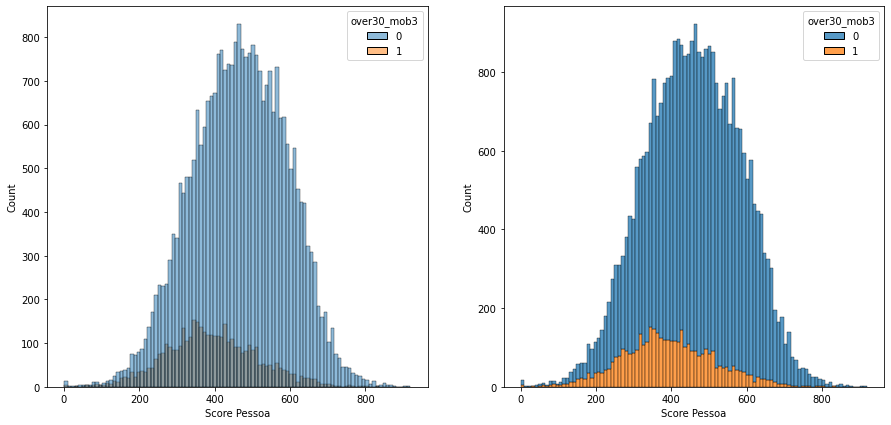

In [34]:
fig = plt.figure(figsize=(15, 7))

fig.add_subplot(121)
sns.histplot(df, x='Score Pessoa', hue=target, bins=100)

fig.add_subplot(122)
sns.histplot(df, x='Score Pessoa', hue=target,  multiple="stack", bins=100)

In [35]:
plot_bads(df.loc[~df['Score Pessoa'].isnull(), target], df.loc[~df['Score Pessoa'].isnull(), 'Score Pessoa'] , 'Bads por decil do score')

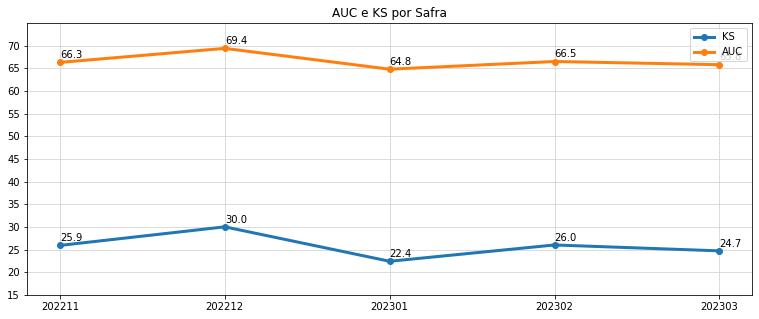

In [36]:
plot_ks_roc(df.loc[~df['Score Pessoa'].isnull()], coluna='safra', indicador=target, score='Score Pessoa')

O Score apresenta uma ordenação, entretanto, sua distribuição é um pouco ruim (visto que o último decil dele está próximo do 600) e no mês de janeiro ele perde muitos pontos em relação ao mês de dezembro (próximo de 5 pontos de AUC e 8 pontos de KS).

## Train/Test/Validation Split

In [37]:
df_val = df.loc[df['safra'] == '202303'].copy()
df_train = df.loc[df['safra'] != '202303'].copy()

print(df_val.shape)
print(df_train.shape)

(6931, 18)
(25911, 18)


Em produtos relacionados a pagamentos, costumo trabalhar com validações Out of Time, visto algumas sazonalidades que o modelo pode enfrentar

## Tratamento de dados

### Tratamento de nulos

In [38]:
df_train.isnull().sum()

safra                      0
id_trx                     0
Data compra                0
Hora da compra             0
Tipo de cliente            0
valor_compra               0
Tempo até utilização       0
over30_mob3                0
risco_validador            0
provedor_email           162
idade_cliente             36
Produto_1                  0
Produto_2                  0
Produto_3                  0
uf                       162
Renda                    169
Score Email             2324
Score Pessoa              83
dtype: int64

#### Provedor email

In [39]:
df_train['provedor_email'].value_counts(normalize=True, dropna=False).reset_index().head(10)

,index,provedor_email
0,gmail,0.6015
1,hotmail,0.2490
2,yahoo,0.0456
3,outlook,0.0266
4,icloud,0.0235
5,live,0.0067
6,NaN,0.0063
7,bol,0.0039
8,uol,0.0033
9,terra,0.0026


In [40]:
df_provedor = df_train['provedor_email'].value_counts(normalize=True, dropna=False).reset_index()
provedor_valido = df_provedor.loc[df_provedor['provedor_email'] >= 0.0065, 'index'].tolist()

df_train['provedor_email_tratado'] = df_train['provedor_email'].apply(lambda x: x if x in provedor_valido else 'other')

df_train['provedor_email_tratado'].value_counts(normalize=True, dropna=False)


gmail     0.6015
hotmail   0.2490
other     0.0472
yahoo     0.0456
outlook   0.0266
icloud    0.0235
live      0.0067
Name: provedor_email_tratado, dtype: float64

O provedor de email eu decidi tranformar os valores nulos e os demais provedores (que apresentam menos do que 0,5% de representatividade) em um grupo 'outros'. Mesmo com esse agrupamento, esse grupo representam menos de 5% do conjunto de dados

#### Idade cliente

In [41]:
df_train.loc[df_train['idade_cliente'].isnull()]

,safra,id_trx,Data compra,Hora da compra,Tipo de cliente,valor_compra,Tempo até utilização,over30_mob3,risco_validador,provedor_email,idade_cliente,Produto_1,Produto_2,Produto_3,uf,Renda,Score Email,Score Pessoa,provedor_email_tratado
1059,202211,1662,2022-11-02,21,1,1885.8700,91 - 120 dias,0,Baixo Risco,NaN,NaN,1,0,0,NaN,NaN,NaN,528.0000,other
2867,202211,4467,2022-11-02,23,1,14511.4200,46 - 60 dias,0,Baixo Risco,NaN,NaN,1,1,0,NaN,NaN,NaN,318.0000,other
3390,202302,5253,2023-02-02,15,1,4050.7800,61 - 90 dias,0,Baixo Risco,NaN,NaN,1,1,0,NaN,1900.0000,NaN,650.0000,other
3512,202211,5453,2022-11-21,16,1,3627.4700,16 - 30 dias,0,Baixo Risco,NaN,NaN,1,1,0,NaN,1200.0000,NaN,444.0000,other
4111,202211,6387,2022-11-02,18,1,2813.2700,46 - 60 dias,0,Baixo Risco,NaN,NaN,1,0,0,NaN,NaN,NaN,518.0000,other
7527,202212,11626,2022-12-19,13,1,1926.6300,7 - 15 dias,0,Baixo Risco,hotmail,NaN,1,0,0,MG,3250.0000,NaN,448.0000,hotmail
7597,202302,11733,2023-02-24,12,1,1336.1000,61 - 90 dias,0,Baixo Risco,NaN,NaN,0,0,0,NaN,NaN,NaN,479.0000,other
7706,202211,11897,2022-11-21,17,1,5214.5300,121 - 150 dias,0,Baixo Risco,NaN,NaN,1,0,0,NaN,4450.0000,50.0000,340.0000,other
8793,202212,13520,2022-12-31,12,1,1270.8200,7 - 15 dias,0,Baixo Risco,gmail,NaN,1,0,0,DF,4300.0000,NaN,500.0000,gmail
9346,202211,14407,2022-11-21,17,1,618.8200,121 - 150 dias,0,Baixo Risco,NaN,NaN,1,0,0,NaN,12000.0000,3.0000,538.0000,other


In [42]:
df_train.groupby(['Tipo de cliente', 'Tempo até utilização'])['idade_cliente'].agg(['count', 'mean'])

count    mean
Tipo de cliente Tempo até utilização               
1               0 -3 dias                 1 55.0000
                121 - 150 dias         1229 32.2482
                151 - 180 dias          796 32.0905
                16 - 30 dias           2690 33.2164
                181 - 210 dias          561 31.7986
                211 - 240 dias          379 33.2269
                241 - 270 dias          302 33.1291
                271 - 300 dias          277 32.5668
                301 - 330 dias          177 31.3729
                31 - 45 dias           2555 32.9127
                331 - 360 dias            7 48.0000
                4 - 6 dias               95 35.8526
                46 - 60 dias           1981 32.7612
                61 - 90 dias           2857 32.4792
                7 - 15 dias             964 33.8714
                91 - 120 dias          2118 31.4556
                mais de 360 dias          9 34.4444
2               0 -3 dias                 4 40.2500
                121 - 150 dias           98 36.8265
                151 - 180 dias           79 34.5570
                16 - 30 dias            307 37.9609
                181 - 210 dias           62 37.9355
                211 - 240 dias           43 34.0465
                241 - 270 dias           30 38.9000
                271 - 300 dias           32 37.9688
                301 - 330 dias           14 33.2857
                31 - 45 dias            332 37.6717
                331 - 360 dias            2 22.0000
                4 - 6 dias               28 41.1786
                46 - 60 dias            218 38.1514
                61 - 90 dias            322 37.6708
                7 - 15 dias             159 38.7736
                91 - 120 dias           221 38.6109
3               121 - 150 dias           28 42.1071
                151 - 180 dias           21 41.1905
                16 - 30 dias             96 41.5000
                181 - 210 dias           18 41.5556
                211 - 240 dias           13 34.0000
                241 - 270 dias            5 32.4000
                271 - 300 dias           13 39.0769
                301 - 330 dias            9 40.8889
                31 - 45 dias             81 38.6049
                4 - 6 dias               16 40.0000
                46 - 60 dias             48 37.8958
                61 - 90 dias             87 39.5632
                7 - 15 dias              48 40.9375
                91 - 120 dias            38 41.4474
4               0 -3 dias                13 45.4615
                121 - 150 dias          311 37.6302
                151 - 180 dias          203 37.1527
                16 - 30 dias           1291 38.6491
                181 - 210 dias          125 37.0080
                211 - 240 dias           92 38.3913
                241 - 270 dias           79 38.6835
                271 - 300 dias           73 35.8356
                301 - 330 dias           59 38.9661
                31 - 45 dias           1097 37.7384
                331 - 360 dias            1 43.0000
                4 - 6 dias              174 39.0632
                46 - 60 dias            686 37.8236
                61 - 90 dias            924 37.7078
                7 - 15 dias             712 38.9326
                91 - 120 dias           565 36.5204

In [43]:
df_train["idade_cliente_tratado"] = df_train["idade_cliente"]
df_train["idade_cliente_tratado"] = df_train.groupby(['Tipo de cliente', 'Tempo até utilização'])["idade_cliente"].transform(lambda x: x.fillna(x.mean()))
df_train["idade_cliente_tratado"] = df_train["idade_cliente_tratado"].astype(int)

df_train["idade_cliente_tratado"].isnull().sum()

0

A idade, decidi fazer uma segmentação simples para fazer um input de média, onde tomei o tipo de cliente e o tempo para tentar ter uma idade média um pouco mais precisa, essa abordagem é um pouco mais trabalhosa para implementar, mas pode ajudar o modelo uma vez que ela trata de maneira diferente os nulos

#### UF

In [44]:
df_train['uf'].value_counts(normalize=True, dropna=False)

SP    0.3312
RJ    0.0912
MG    0.0734
GO    0.0619
RS    0.0513
PR    0.0477
DF    0.0475
SC    0.0413
MT    0.0391
BA    0.0306
PA    0.0234
PE    0.0224
MS    0.0193
AM    0.0182
ES    0.0172
CE    0.0167
MA    0.0137
PB    0.0071
NaN   0.0063
SE    0.0063
RO    0.0061
AL    0.0061
RN    0.0057
PI    0.0052
TO    0.0044
AP    0.0039
RR    0.0018
AC    0.0011
Name: uf, dtype: float64

In [45]:
df_train['uf'].nunique()

27

In [46]:
df_train.groupby(['risco_validador'])["uf"].agg(pd.Series.mode)

risco_validador
Alto Risco     DF
Baixo Risco    SP
Medio Risco    SP
Name: uf, dtype: object

In [47]:
df_train["uf_tratado"] = df_train["uf"]
df_train["uf_tratado"].fillna('SP', inplace=True)
df_train["uf_tratado"].isnull().sum()

0

Para UF, percebi que existiam pouco cliente de outros estados e a segmentação não fugia muito da predominância do estado de SP, por conta disso, decidi que iria completar os nulos como SP simplesmente

#### Renda

In [48]:
df_train["Renda_tratado"] = df_train["Renda"]
df_train["Renda_tratado"] = df_train.groupby(['uf_tratado', 'risco_validador'])["Renda"].transform(lambda x: x.fillna(x.mean()))
df_train["Renda_tratado"].isnull().sum()

1

In [49]:
df_train["Renda_tratado"] = df_train.groupby(['uf_tratado'])["Renda"].transform(lambda x: x.fillna(x.mean()))
df_train["Renda_tratado"].isnull().sum()

0

In [50]:
df_train["Renda_tratado"] = df_train["Renda_tratado"].astype(int)

Para renda, coloquei a renda média de cada estado, uma vez que observei que a médias dos estados difere bastante entre elas

#### Score Pessoa

In [51]:
optb_renda = OptimalBinning(name='Renda', dtype="numerical", solver="cp")
optb_renda.fit(df_train['Renda_tratado'], df_train['over30_mob3'])
df_train['Renda_binned'] = optb_renda.transform(df_train['Renda_tratado'])
binning_table_renda = optb_renda.binning_table
binning_table_renda.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1325.00)",3449,0.1331,2869,580,0.1682,-0.3649,0.0203,0.0025
1,"[1325.00, 2475.00)",4253,0.1641,3612,641,0.1507,-0.2346,0.0099,0.0012
2,"[2475.00, 4375.00)",8010,0.3091,7005,1005,0.1255,-0.0220,0.0002,0.0000
3,"[4375.00, 5562.50)",2761,0.1066,2451,310,0.1123,0.1041,0.0011,0.0001
4,"[5562.50, 10275.00)",3497,0.1350,3177,320,0.0915,0.3317,0.0131,0.0016
5,"[10275.00, 24525.00)",2626,0.1013,2395,231,0.0880,0.3751,0.0124,0.0015
6,"[24525.00, inf)",1315,0.0508,1213,102,0.0776,0.5123,0.0110,0.0014
7,Special,0,0.0000,0,0,0.0000,0.0000,0.0000,0.0000
8,Missing,0,0.0000,0,0,0.0000,0.0000,0.0000,0.0000
Totals,,25911,1.0000,22722,3189,0.1231,,0.0678,0.0084


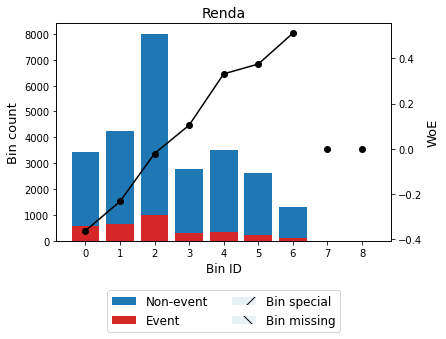

In [52]:
binning_table_renda.plot(metric="woe")

In [53]:
optb_idade = OptimalBinning(name='idade_cliente_tratado', dtype="numerical", solver="cp")
optb_idade.fit(df_train['idade_cliente_tratado'], df_train['over30_mob3'])
df_train['idade_cliente_binned'] = optb_idade.transform(df_train['Renda_tratado'])
binning_table_idade = optb_idade.binning_table
binning_table_idade.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 22.50)",7312,0.2822,6598,714,0.0976,0.2600,0.0173,0.0022
1,"[22.50, 25.50)",1653,0.0638,1364,289,0.1748,-0.4119,0.0126,0.0016
2,"[25.50, 28.50)",1951,0.0753,1658,293,0.1502,-0.2304,0.0044,0.0005
3,"[28.50, 36.50)",4814,0.1858,4131,683,0.1419,-0.1638,0.0053,0.0007
4,"[36.50, 39.50)",1617,0.0624,1405,212,0.1311,-0.0724,0.0003,0.0000
5,"[39.50, 44.50)",2605,0.1005,2284,321,0.1232,-0.0014,0.0000,0.0000
6,"[44.50, 56.50)",4440,0.1714,3911,529,0.1191,0.0369,0.0002,0.0000
7,"[56.50, inf)",1519,0.0586,1371,148,0.0974,0.2625,0.0037,0.0005
8,Special,0,0.0000,0,0,0.0000,0.0000,0.0000,0.0000
9,Missing,0,0.0000,0,0,0.0000,0.0000,0.0000,0.0000


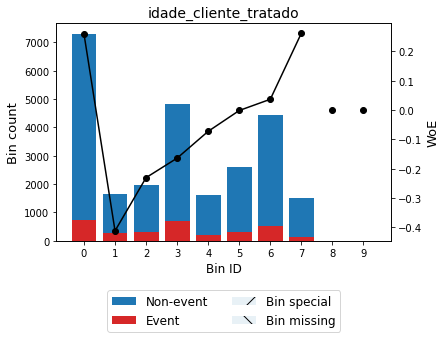

In [54]:
binning_table_idade.plot(metric="woe")

In [55]:
df_train.groupby(['Renda_binned', 'idade_cliente_binned', 'risco_validador', 'uf_tratado'])['Score Pessoa'].mean().head(20)

Renda_binned  idade_cliente_binned  risco_validador  uf_tratado
-0.3649       0.2600                Baixo Risco      CE           648.0000
                                                     ES           552.0000
                                                     GO           414.0000
                                                     MA           416.0000
                                                     MG           470.0000
                                                     MT           679.0000
                                                     PB           424.0000
                                                     RJ           641.0000
                                                     RS           401.2500
                                                     SP           511.3333
                                    Medio Risco      CE           471.0000
                                                     MT           398.0000
                                    

In [56]:
df_train["Score Pessoa_tratado"] = df_train["Score Pessoa"]
df_train["Score Pessoa_tratado"] = df_train.groupby(['Renda_binned', 'idade_cliente_binned', 'risco_validador', 'uf_tratado'])["Score Pessoa"].transform(lambda x: x.fillna(x.mean()))
print(df_train["Score Pessoa_tratado"].isnull().sum())
df_train["Score Pessoa_tratado"] = df_train["Score Pessoa_tratado"].astype(int)

0


Para o Score Pessoa, pensando nele como um score de Bureau, decidi realizar a segmentação utilizando a idade, renda, risco e UF, como idade e renda possuem uma variedade muito grande de valores, decidi utilizar a biblioteca OptBinning para agrupar os dados em categorias, e com essas categorias, realizar o input dos dados faltantes.

#### Score Email

##### Análise de segmentações para completar valores nulos

In [57]:
df_train.groupby(['provedor_email_tratado', 'risco_validador', 'Tipo de cliente'])["Score Email"].mean().head(10)

provedor_email_tratado  risco_validador  Tipo de cliente
gmail                   Alto Risco       1                 130.9259
                                         2                 137.0000
                                         3                 180.0000
                                         4                 114.5278
                        Baixo Risco      1                 124.7551
                                         2                 101.3920
                                         3                  74.1935
                                         4                  91.2594
                        Medio Risco      1                 148.0991
                                         2                 130.0153
Name: Score Email, dtype: float64

In [58]:
df_train["Score Email_tratado"] = df_train["Score Email"]
df_train["Score Email_tratado"] = df_train.groupby(['provedor_email_tratado', 'risco_validador', 'Tipo de cliente', 'uf_tratado'])["Score Email"].transform(lambda x: x.fillna(x.median()))
print(df_train["Score Email_tratado"].isnull().sum())

df_train["Score Email_tratado"] = df_train.groupby(['provedor_email_tratado', 'risco_validador', 'Tipo de cliente'])["Score Email"].transform(lambda x: x.fillna(x.mean()))
print(df_train["Score Email_tratado"].isnull().sum())

df_train["Score Email_tratado"] = df_train.groupby(['provedor_email_tratado', 'risco_validador'])["Score Email"].transform(lambda x: x.fillna(x.mean()))
print(df_train["Score Email_tratado"].isnull().sum())

df_train["Score Email_tratado"] = df_train["Score Email_tratado"].astype(int)

33
1
0


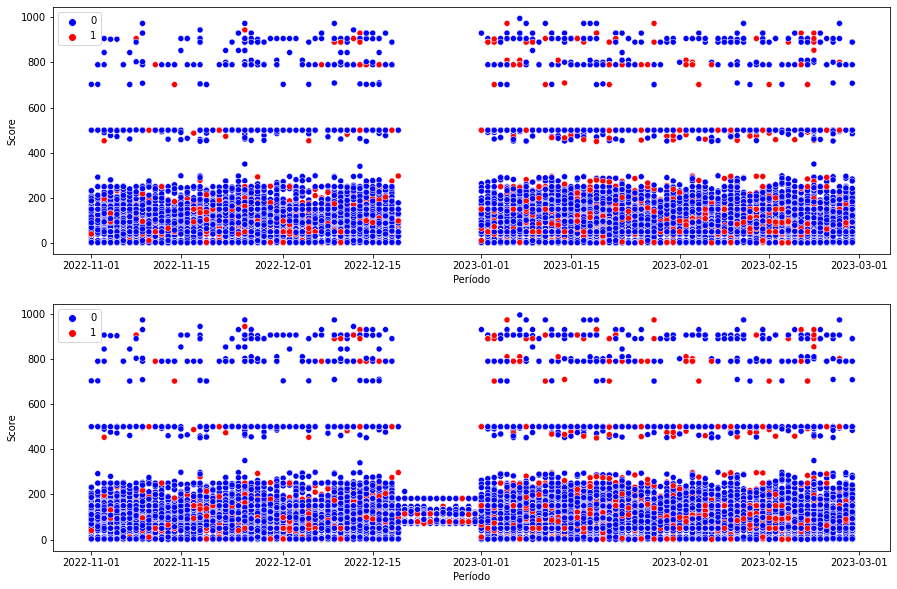

In [59]:
fig = plt.figure(figsize=(15, 10))

fig.add_subplot(211)
ax = sns.scatterplot(data=df_train, x="Data compra", y="Score Email", hue=target, palette=['blue', 'red'])
ax.set_xlabel('Período')
ax.set_ylabel('Score')
ax.legend(loc='upper left')


fig.add_subplot(212)
ax = sns.scatterplot(data=df_train, x="Data compra", y="Score Email_tratado", hue=target, palette=['blue', 'red'])
ax.set_xlabel('Período')
ax.set_ylabel('Score')
ax.legend(loc='upper left')

Após realizar o input baseado em uma segmentação simplificada, observei que os resultados foram longe de satisfatórios, pois os valores imputados se comportaram de forma muito diferente dos demais dados, por cotna disso, decidi realizar um input baseado em KNNImputer, é uma técnica um pouco mais complexa mas pode gerar resultados melhores

In [60]:
df_train["Score Email_tratado"] = df_train["Score Email"]

In [61]:
colunas = ['safra', 'id_trx', 'Hora da compra', 'Tipo de cliente',
       'valor_compra',  'Produto_1', 'Produto_2', 'Produto_3', 'idade_cliente_tratado',
       'Renda_tratado', 'Score Pessoa_tratado', 'Score Email_tratado']

In [62]:
df_train[colunas].shape

(25911, 12)

In [63]:
df_train[colunas].isnull().sum()

safra                       0
id_trx                      0
Hora da compra              0
Tipo de cliente             0
valor_compra                0
Produto_1                   0
Produto_2                   0
Produto_3                   0
idade_cliente_tratado       0
Renda_tratado               0
Score Pessoa_tratado        0
Score Email_tratado      2324
dtype: int64

In [64]:
imputer = KNNImputer(n_neighbors=5)
df_train_2 = pd.DataFrame(imputer.fit_transform(df_train[colunas]), columns=colunas)


In [65]:
df_train_2[colunas].isnull().sum()

safra                    0
id_trx                   0
Hora da compra           0
Tipo de cliente          0
valor_compra             0
Produto_1                0
Produto_2                0
Produto_3                0
idade_cliente_tratado    0
Renda_tratado            0
Score Pessoa_tratado     0
Score Email_tratado      0
dtype: int64

In [66]:
df_train_2['id_trx'] = df_train_2['id_trx'].astype(int)
df_train_2['Score Email_tratado'] = df_train_2['Score Email_tratado'].astype(int)
df_train_2[['id_trx', 'Score Email_tratado']]

,id_trx,Score Email_tratado
0,1,150
1,3,82
2,8,57
3,12,50
4,15,63
...,...,...
25906,32764,154
25907,32780,137
25908,32793,90
25909,32804,79


In [67]:
df_train = df_train.drop(columns='Score Email_tratado').merge(df_train_2[['id_trx', 'Score Email_tratado']], on='id_trx')

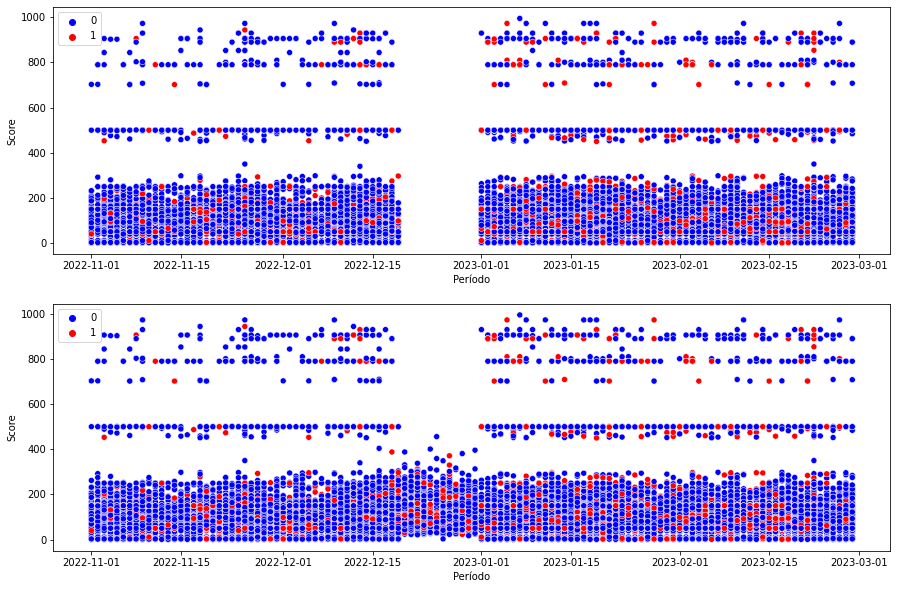

In [68]:
fig = plt.figure(figsize=(15, 10))

fig.add_subplot(211)
ax = sns.scatterplot(data=df_train, x="Data compra", y="Score Email", hue=target, palette=['blue', 'red'])
ax.set_xlabel('Período')
ax.set_ylabel('Score')
ax.legend(loc='upper left')


fig.add_subplot(212)
ax = sns.scatterplot(data=df_train, x="Data compra", y="Score Email_tratado", hue=target, palette=['blue', 'red'])
ax.set_xlabel('Período')
ax.set_ylabel('Score')
ax.legend(loc='upper left')

Apesar de ainda não ter a mesma característica dos dados originais, achei que estavam melhores que a segmentação que havia utilizado anteriormente.

### Encoding

Com o intuito de facilitar as segmentações da árvore, decidi realizar o encoding das variáveis categóricas

In [69]:
df_train[['safra', 'id_trx', 'Data compra', 'Hora da compra',
          'Tipo de cliente', 'valor_compra', 'Tempo até utilização',
          'risco_validador', 'Produto_1', 'Produto_2', 'Produto_3',
          'provedor_email_tratado', 'idade_cliente_tratado', 'uf_tratado',
          'Renda_tratado', 'Score Pessoa_tratado', 'Score Email_tratado']].info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 25911 entries, 0 to 25910
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   safra                   25911 non-null  object        
 1   id_trx                  25911 non-null  int64         
 2   Data compra             25911 non-null  datetime64[ns]
 3   Hora da compra          25911 non-null  int64         
 4   Tipo de cliente         25911 non-null  int64         
 5   valor_compra            25911 non-null  float64       
 6   Tempo até utilização    25911 non-null  object        
 7   risco_validador         25911 non-null  object        
 8   Produto_1               25911 non-null  int64         
 9   Produto_2               25911 non-null  int64         
 10  Produto_3               25911 non-null  int64         
 11  provedor_email_tratado  25911 non-null  object        
 12  idade_cliente_tratado   25911 non-null  int32 

#### Tempo até utilização

In [70]:
enc = LabelEncoder()

enc.fit(order_x)
enc.classes_

array(['0 -3 dias', '121 - 150 dias', '151 - 180 dias', '16 - 30 dias',
       '181 - 210 dias', '211 - 240 dias', '241 - 270 dias',
       '271 - 300 dias', '301 - 330 dias', '31 - 45 dias',
       '331 - 360 dias', '4 - 6 dias', '46 - 60 dias', '61 - 90 dias',
       '7 - 15 dias', '91 - 120 dias', 'mais de 360 dias'], dtype='<U16')

In [71]:
df_train['Tempo até utilização_encoded'] = enc.transform(df_train['Tempo até utilização'])

In [72]:
df_train[['Tempo até utilização', 'Tempo até utilização_encoded']].sample(10, random_state=0)

,Tempo até utilização,Tempo até utilização_encoded
6184,91 - 120 dias,15
19806,31 - 45 dias,9
7104,91 - 120 dias,15
21856,61 - 90 dias,13
10626,7 - 15 dias,14
23575,91 - 120 dias,15
7807,46 - 60 dias,12
25579,16 - 30 dias,3
5427,121 - 150 dias,1
25782,16 - 30 dias,3


Para o tempo de utilização utilizei um encoding simples, apenas tomando cuidado para que a datas menores tivessem números menores

#### Risco Validador

In [73]:
df_train['risco_validador'].unique()

array(['Baixo Risco', 'Medio Risco', 'Alto Risco'], dtype=object)

In [74]:
risco_dict = {'Baixo Risco': 0,
              'Medio Risco': 1,
              'Alto Risco': 2}

df_train['risco_validador_encoded'] = df_train['risco_validador'].map(risco_dict)

In [75]:
df_train[['risco_validador', 'risco_validador_encoded']].sample(5, random_state=0)

,risco_validador,risco_validador_encoded
6184,Baixo Risco,0
19806,Baixo Risco,0
7104,Baixo Risco,0
21856,Medio Risco,1
10626,Baixo Risco,0


Também utilizei um encoding simples

#### Provedor email

In [76]:
df_train['provedor_email_tratado'].unique()

array(['hotmail', 'other', 'gmail', 'live', 'icloud', 'yahoo', 'outlook'],
      dtype=object)

In [77]:
email_dict = {'other': 0,
              'gmail': 1,
              'icloud': 2,
              'yahoo': 3,
              'live': 4,
              'outlook': 4,
              'hotmail': 4}

df_train['provedor_email_encoded'] = df_train['provedor_email_tratado'].map(email_dict)


In [78]:
df_train[['provedor_email_tratado', 'provedor_email_encoded']].sample(5, random_state=0)

,provedor_email_tratado,provedor_email_encoded
6184,gmail,1
19806,hotmail,4
7104,hotmail,4
21856,gmail,1
10626,gmail,1


Nesse realizei um encoding simples, entretanto, agrupei os provedores `live`, `outlook` e `hotmail`, pois são todos domínios pertencentes à Microsoft

#### UF

In [79]:
from category_encoders import CatBoostEncoder
encoder = CatBoostEncoder()
df_train['uf_encoded'] = encoder.fit_transform(df_train['uf_tratado'], df_train[target])

df_train[['uf_tratado', 'uf_encoded']].sample(5, random_state=0)

,uf_tratado,uf_encoded
6184,SP,0.1295
19806,RN,0.2678
7104,BA,0.1374
21856,SP,0.1125
10626,SC,0.1275


Para o encoding das UF, decidi utilizar o CatBoostEncoder, ele possui como vantagem o fato de realizar o encoding de acordo com a variável target

## Features

In [80]:
features = ['Hora da compra', 'Tipo de cliente', 'valor_compra', 'Tempo até utilização_encoded', 
            'risco_validador_encoded', 'Produto_1', 'Produto_2', 'Produto_3',
            'provedor_email_encoded', 'idade_cliente_tratado', 'uf_encoded',
            'Renda_tratado', 'Score Pessoa_tratado', 'Score Email_tratado']

len(features)

14

In [81]:
df_train[features + [target]].sample(5)

,Hora da compra,Tipo de cliente,valor_compra,Tempo até utilização_encoded,risco_validador_encoded,Produto_1,Produto_2,Produto_3,provedor_email_encoded,idade_cliente_tratado,uf_encoded,Renda_tratado,Score Pessoa_tratado,Score Email_tratado,over30_mob3
9890,11,1,1265.2800,14,0,1,0,0,4,28,0.1248,1500,353,92,0
7226,8,1,4147.1600,13,0,1,0,0,2,25,0.1087,4200,357,95,0
14980,21,1,1411.8000,9,0,1,0,0,4,54,0.1339,4350,574,51,0
14497,9,1,873.7500,13,1,1,0,0,1,25,0.1219,2250,258,122,1
8073,20,1,3499.3200,15,0,1,0,0,3,37,0.1168,3650,392,105,0


In [82]:
feats, removed_feats = remove_feats_by_freq(df_train, features, threshold=0.9)
len(feats)

Interation: 2
Features: 12


12

In [83]:
print(removed_feats)

['Produto_1', 'Produto_3']


## Optuna

In [84]:
# X = df_train[feats]
# y = df_train[target]

# def objective(trial, X=X, y=y):

#     learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
#     num_leaves = trial.suggest_int('num_leaves', 2, 128)
#     max_depth = trial.suggest_int('max_depth', 1, 10)
#     min_child_samples = trial.suggest_int('min_child_samples', 1, 25)
#     subsample = trial.suggest_float('subsample', 0.5, 1, step=0.1)
#     colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1, step=0.1)
#     n_estimators = trial.suggest_int('n_estimators', 300, 700)

#     avg_roc = 0
#     kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     for tr, ts in kf.split(X, y):
#         Xtr, Xts = X.iloc[tr], X.iloc[ts]
#         ytr, yts = y.iloc[tr], y.iloc[ts]

#         class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=[0, 1], y=ytr)
#         class_weights = dict(enumerate(class_weights))
        
#         modelo = LGBMClassifier(learning_rate=learning_rate,
#                                 num_leaves=num_leaves,
#                                 max_depth=max_depth,
#                                 min_child_samples=min_child_samples,
#                                 subsample=subsample,
#                                 colsample_bytree=colsample_bytree,
#                                 n_estimators=n_estimators,
#                                 class_weight=class_weights,
#                                 random_state=0,
#                                 subsample_freq=1,
#                                 )

#         modelo.fit(Xtr, ytr, eval_set=[(Xts, yts), (Xtr, ytr)],
#                    verbose=False, eval_metric='auc', early_stopping_rounds=10)
#         ypred = modelo.predict_proba(Xts)[:, 1]

#         avg_roc += roc_auc_score(yts, ypred)

#     return avg_roc / 5

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=500)
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)


In [85]:
results = list({'learning_rate': 0.09227622941793247, 'num_leaves': 92, 'max_depth': 4, 'min_child_samples': 4, 'subsample': 0.9, 'colsample_bytree': 0.6, 'n_estimators': 378}.values())
# results = list(study.best_trial.params.values())

learning_rate = results[0]
num_leaves = results[1]
max_depth = results[2]
min_child_samples = results[3]
subsample = results[4]
colsample_bytree = results[5]
n_estimators = results[6]

## Treinamento

### KFold

In [86]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1995)

feature_importance_df = pd.DataFrame()

X = df_train[feats]
y = df_train[target]

kf_results = {}
y_pred_oof = np.zeros(X.shape[0])

for i, (tr, ts) in enumerate(kf.split(X, y)):
    kf_results[i] = {}
    
    Xtr, ytr = X.iloc[tr], y.iloc[tr]
    Xval, yval = X.iloc[ts], y.iloc[ts]
    
    class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=[0, 1], y=ytr)
    class_weights = dict(enumerate(class_weights))
    
    model = LGBMClassifier(learning_rate=learning_rate,
                           num_leaves=num_leaves,
                           max_depth=max_depth,
                           min_child_samples=min_child_samples,
                           subsample=subsample,
                           colsample_bytree=colsample_bytree,
                           n_estimators=n_estimators,
                           class_weight=class_weights,
                           random_state=0,
                           subsample_freq=1,)

    model.fit(Xtr, ytr)
    
    ypred = model.predict_proba(Xval)[:, 1]

    kf_results[i]['auroc'] = roc_auc_score(yval, ypred)
    
    fold_importance_df = pd.DataFrame(sorted(zip(X.columns, model.feature_importances_)), columns=['Feature', 'Value'])
    fold_importance_df["Fold"] = i
    
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    y_pred_oof[ts] = ypred

X_copy = X.copy()

X_copy['score'] = (1- y_pred_oof) * 1000

df_train['score'] = X_copy['score']

auroc = []
ks = []

for _, results in kf_results.items():
    auroc.append(results.get('auroc'))
            
print("Média AUROC: {:.4f}".format(np.mean(auroc)))

Média AUROC: 0.6902


### Análise do modelo

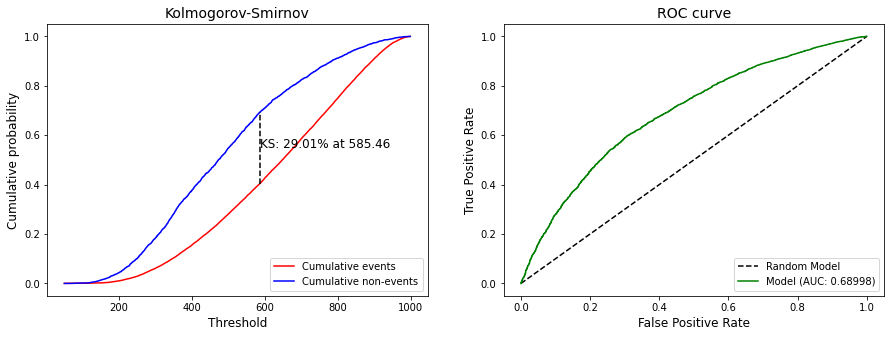

In [87]:
fig = plt.figure(figsize=(15, 5))

fig.add_subplot(121)
plot_ks(df_train[target] * -1 + 1, df_train['score'])

fig.add_subplot(122)
plot_auc_roc(df_train[target] * -1 + 1, df_train['score'])

In [88]:
optb = OptimalBinning(name='score', dtype="numerical", solver="cp")
optb.fit(df_train['score'], df_train[target])
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 271.88)",1399,0.0540,953,446,0.3188,-1.2043,0.1179,0.0139
1,"[271.88, 364.60)",2288,0.0883,1721,567,0.2478,-0.8533,0.0871,0.0106
2,"[364.60, 429.47)",1988,0.0767,1627,361,0.1816,-0.4580,0.0191,0.0024
3,"[429.47, 536.79)",3843,0.1483,3261,582,0.1514,-0.2403,0.0094,0.0012
4,"[536.79, 585.46)",1840,0.0710,1586,254,0.1380,-0.1320,0.0013,0.0002
5,"[585.46, 621.50)",1469,0.0567,1309,160,0.1089,0.1382,0.0010,0.0001
6,"[621.50, 659.34)",1454,0.0561,1323,131,0.0901,0.3488,0.0060,0.0007
7,"[659.34, 755.19)",3880,0.1497,3578,302,0.0778,0.5085,0.0319,0.0039
8,"[755.19, 788.19)",1312,0.0506,1226,86,0.0655,0.6935,0.0187,0.0023
9,"[788.19, 844.43)",2259,0.0872,2135,124,0.0549,0.8823,0.0486,0.0059


<Axes: xlabel='score', ylabel='Count'>

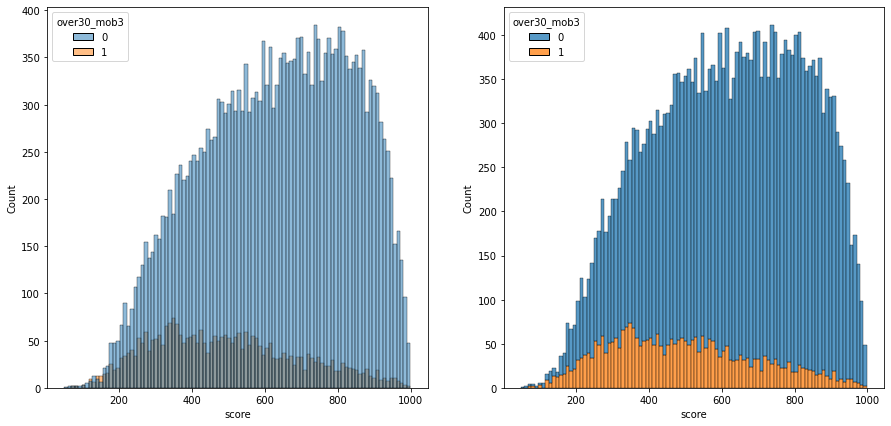

In [89]:
fig = plt.figure(figsize=(15, 7))

fig.add_subplot(121)
sns.histplot(df_train, x='score', hue=target, bins=100)

fig.add_subplot(122)
sns.histplot(df_train, x='score', hue=target,  multiple="stack", bins=100)

In [90]:
plot_bads(df_train[target], df_train['score'] , 'Bads FPD por decil do score')

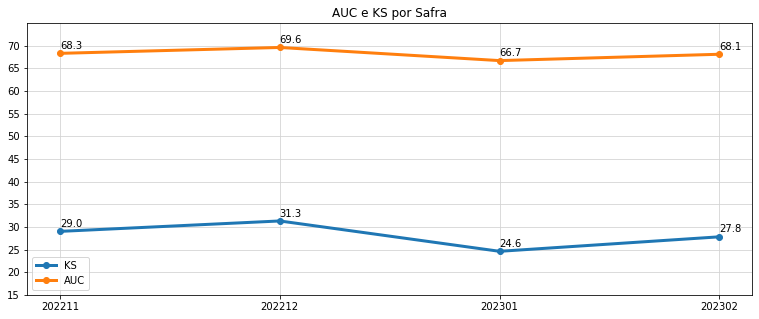

In [91]:
plot_ks_roc(df_train, coluna='safra', indicador=target, score='score')

## Feature Importance

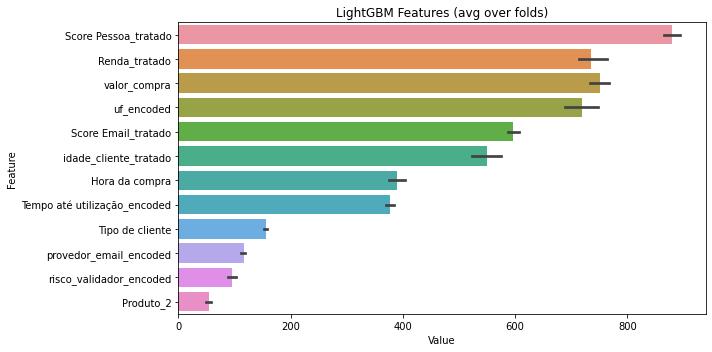

In [92]:
plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_importance_df.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [93]:
# ranking all feature by avg importance score from Kfold
all_features = feature_importance_df[['Feature', 'Value']].groupby("Feature").mean().sort_values(by="Value", ascending=False)
all_features.reset_index(inplace=True)
important_features = list(all_features.loc[all_features['Value'] >= all_features['Value'].max() * 0.1, 'Feature'])
len(important_features)

11

### Treinamento com melhores features

In [94]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1995)

feature_importance_df = pd.DataFrame()

X = df_train[important_features]
y = df_train[target]

kf_results = {}
y_pred_oof = np.zeros(X.shape[0])

for i, (tr, ts) in enumerate(kf.split(X, y)):
    kf_results[i] = {}
    
    Xtr, ytr = X.iloc[tr], y.iloc[tr]
    Xval, yval = X.iloc[ts], y.iloc[ts]
    
    class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=[0, 1], y=ytr)
    class_weights = dict(enumerate(class_weights))
    
    model = LGBMClassifier(learning_rate=learning_rate,
                           num_leaves=num_leaves,
                           max_depth=max_depth,
                           min_child_samples=min_child_samples,
                           subsample=subsample,
                           colsample_bytree=colsample_bytree,
                           n_estimators=n_estimators,
                           class_weight=class_weights,
                           random_state=0,
                           subsample_freq=1,)

    model.fit(Xtr, ytr)
    
    ypred = model.predict_proba(Xval)[:, 1]

    kf_results[i]['auroc'] = roc_auc_score(yval, ypred)
    
    fold_importance_df = pd.DataFrame(sorted(zip(X.columns, model.feature_importances_)), columns=['Feature', 'Value'])
    fold_importance_df["Fold"] = i
    
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    y_pred_oof[ts] = ypred

X_copy = X.copy()

X_copy['score'] = (1- y_pred_oof) * 1000

df_train['score'] = X_copy['score']

auroc = []
ks = []

for _, results in kf_results.items():
    auroc.append(results.get('auroc'))
            
print("Média AUROC: {:.4f}".format(np.mean(auroc)))

Média AUROC: 0.6887


### Análise do modelo

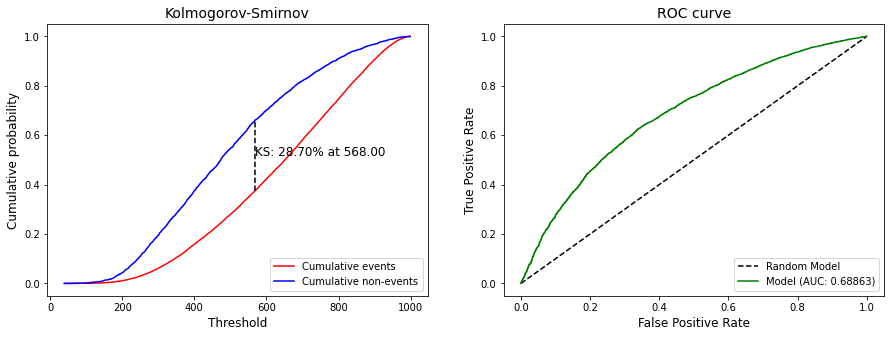

In [95]:
fig = plt.figure(figsize=(15, 5))

fig.add_subplot(121)
plot_ks(df_train[target] * -1 + 1, df_train['score'])

fig.add_subplot(122)
plot_auc_roc(df_train[target] * -1 + 1, df_train['score'])

In [96]:
optb = OptimalBinning(name='score', dtype="numerical", solver="cp")
optb.fit(df_train['score'], df_train[target])
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 278.24)",1548,0.0597,1031,517,0.3340,-1.2734,0.1487,0.0174
1,"[278.24, 335.11)",1334,0.0515,1021,313,0.2346,-0.7813,0.0416,0.0051
2,"[335.11, 405.33)",2084,0.0804,1681,403,0.1934,-0.5354,0.0281,0.0035
3,"[405.33, 478.53)",2376,0.0917,1970,406,0.1709,-0.3842,0.0156,0.0019
4,"[478.53, 556.01)",2828,0.1091,2417,411,0.1453,-0.1919,0.0043,0.0005
5,"[556.01, 594.00)",1447,0.0558,1279,168,0.1161,0.0662,0.0002,0.0000
6,"[594.00, 635.01)",1567,0.0605,1399,168,0.1072,0.1559,0.0014,0.0002
7,"[635.01, 686.87)",2085,0.0805,1887,198,0.0950,0.2909,0.0061,0.0008
8,"[686.87, 777.31)",3702,0.1429,3436,266,0.0719,0.5949,0.0403,0.0050
9,"[777.31, 834.07)",2296,0.0886,2157,139,0.0605,0.7784,0.0400,0.0049


<Axes: xlabel='score', ylabel='Count'>

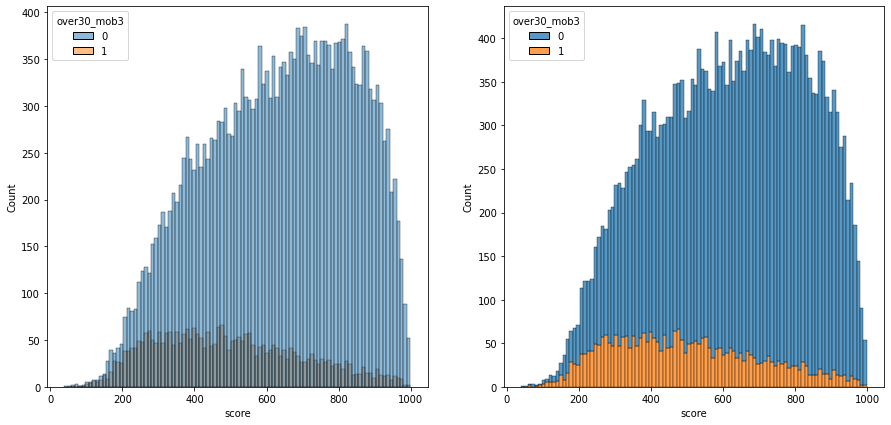

In [97]:
fig = plt.figure(figsize=(15, 7))

fig.add_subplot(121)
sns.histplot(df_train, x='score', hue=target, bins=100)

fig.add_subplot(122)
sns.histplot(df_train, x='score', hue=target,  multiple="stack", bins=100)

In [98]:
plot_bads(df_train[target], df_train['score'], 'Bads por decil do score')

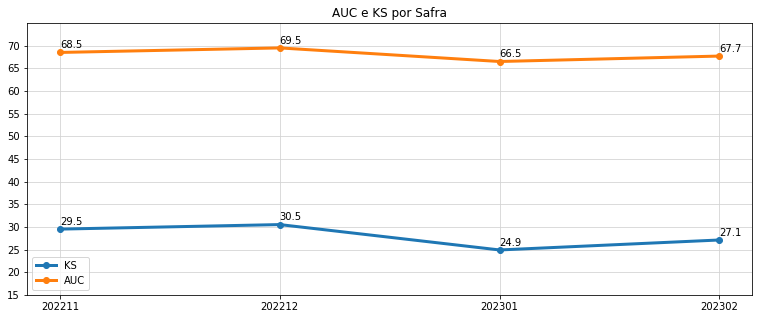

In [99]:
plot_ks_roc(df_train, coluna='safra', indicador=target, score='score')

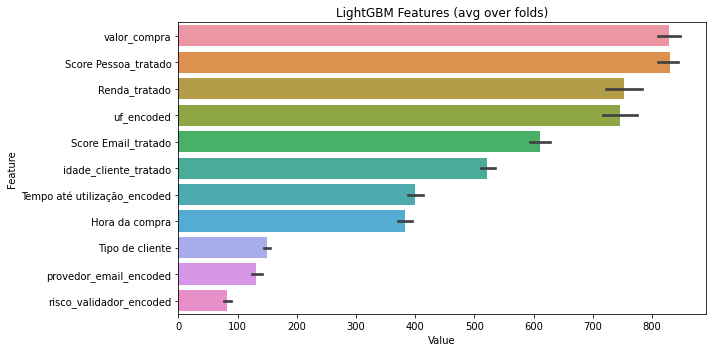

In [100]:
plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_importance_df.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

## Treinamento Final

In [101]:
X = df_train[important_features]
y = df_train[target]


class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=[0, 1], y=y)
class_weights = dict(enumerate(class_weights))

model = LGBMClassifier(learning_rate=learning_rate,
                       num_leaves=num_leaves,
                       max_depth=max_depth,
                       min_child_samples=min_child_samples,
                       subsample=subsample,
                       colsample_bytree=colsample_bytree,
                       n_estimators=n_estimators,
                       class_weight=class_weights,
                       random_state=0,
                       subsample_freq=1,)

model.fit(X, y)

feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, X.columns)), columns=['Value','Feature'])

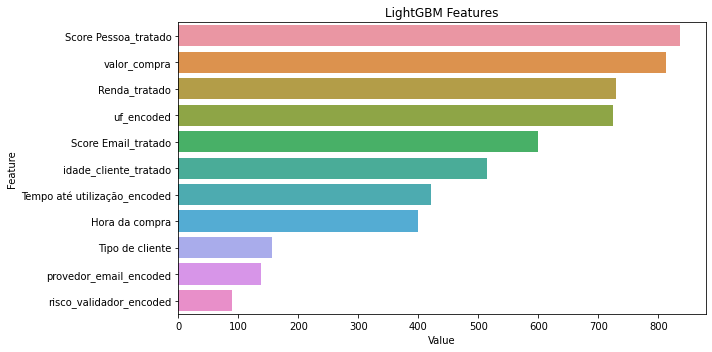

In [102]:
plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

## Validação final

In [103]:
df_val.isnull().sum()

safra                    0
id_trx                   0
Data compra              0
Hora da compra           0
Tipo de cliente          0
valor_compra             0
Tempo até utilização     0
over30_mob3              0
risco_validador          0
provedor_email          15
idade_cliente            9
Produto_1                0
Produto_2                0
Produto_3                0
uf                      15
Renda                    0
Score Email             17
Score Pessoa             0
dtype: int64

### Tratamento

#### Tempo Até utilização

In [104]:
df_val['Tempo_até_utilização_encoded'] = enc.transform(df_val['Tempo até utilização'])

#### Risco Validador

In [105]:
df_val['risco_validador_encoded'] = df_val['risco_validador'].map(risco_dict)

#### Provedor Email

In [106]:
df_val['provedor_email_tratado'] = df_val['provedor_email'].apply(lambda x: x if x in provedor_valido else 'other')
df_val['provedor_email_encoded'] = df_val['provedor_email_tratado'].map(email_dict)

#### Idade cliente

In [107]:
df_idade_fill = df_train.groupby(['Tipo de cliente', 'Tempo até utilização'])["idade_cliente"].mean().reset_index()

In [108]:
df_val["idade_cliente_tratado"] = df_val["idade_cliente"]

for i in df_val.loc[df_val["idade_cliente_tratado"].isnull()].index:
    df_val.loc[i, "idade_cliente_tratado"] = df_idade_fill.loc[(df_idade_fill['Tipo de cliente'] == df_val.loc[i, "Tipo de cliente"]) & (df_idade_fill['Tempo até utilização'] == df_val.loc[i, "Tempo até utilização"]), 'idade_cliente'].values


df_val["idade_cliente_tratado"].isnull().sum()

0

#### UF

In [109]:
# risco_validador
# Alto Risco     DF
# Baixo Risco    SP
# Medio Risco    SP
# Name: uf, dtype: object

In [110]:
df_val["uf_tratado"] = df_val["uf"]
df_val.loc[df_val["risco_validador"] == 'Alto Risco', 'uf_tratado'].fillna('DF', inplace=True)
df_val['uf_tratado'].fillna('SP', inplace=True)
df_val["uf_tratado"].isnull().sum()

0

In [111]:
df_val['uf_encoded'] = encoder.transform(df_val['uf_tratado'])

#### Score email

In [112]:
df_val['Renda_tratado'] = df_val['Renda']
df_val['Score Pessoa_tratado'] = df_val['Score Pessoa']
df_val['Score Email_tratado'] = df_val['Score Email']

df_val_2 = pd.DataFrame(imputer.transform(df_val[colunas]), columns=colunas)

df_val = df_val.drop(columns='Score Email_tratado').merge(df_val_2[['id_trx', 'Score Email_tratado']], on='id_trx')

In [113]:
df_val.rename(columns={'Score Pessoa_tratado': 'Score_Pessoa_tratado',
                       'Score Email_tratado': 'Score_Email_tratado',
                       'Hora da compra': 'Hora_da_compra',
                       'Tipo de cliente': 'Tipo_de_cliente'}, inplace=True)


### Score base validação

In [114]:
df_val['pred_proba'] = model.predict_proba(df_val[model.feature_name_])[:, 1]

df_val['score'] = (1 - df_val['pred_proba']) * 1000

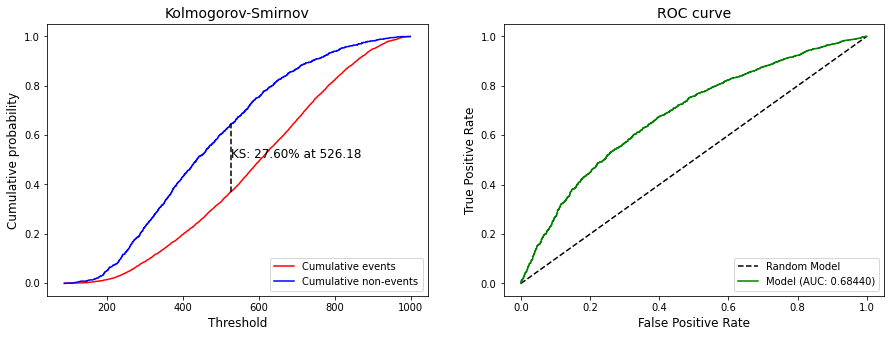

In [115]:
fig = plt.figure(figsize=(15, 5))

fig.add_subplot(121)
plot_ks(df_val[target] * -1 + 1, df_val['score'])

fig.add_subplot(122)
plot_auc_roc(df_val[target] * -1 + 1, df_val['score'])

<Axes: xlabel='score', ylabel='Count'>

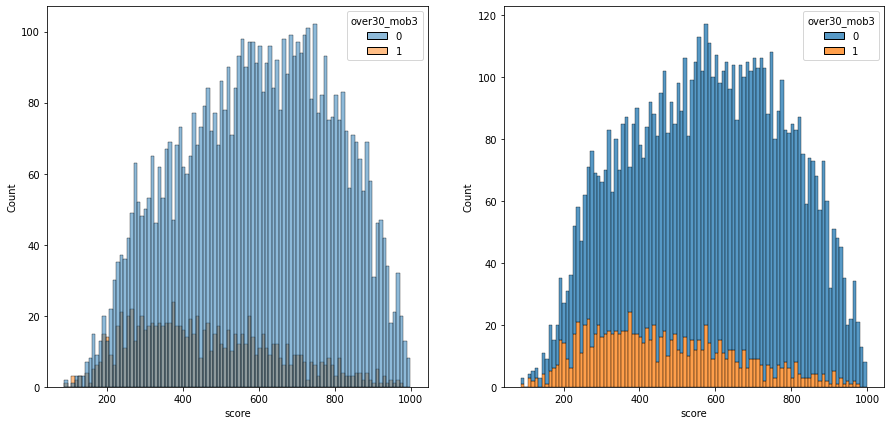

In [116]:
fig = plt.figure(figsize=(15, 7))

fig.add_subplot(121)
sns.histplot(df_val, x='score', hue=target, bins=100)

fig.add_subplot(122)
sns.histplot(df_val, x='score', hue=target,  multiple="stack", bins=100)

In [117]:
print('Análise OptBinning')
print('='*50)
optb = OptimalBinning(name='score', dtype="numerical", solver="cp")
optb.fit(df_val['score'], df_val[target])
binning_table = optb.binning_table
binning_table.build()

Análise OptBinning


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 267.46)",499,0.0720,336,163,0.3267,-1.0971,0.1233,0.0147
1,"[267.46, 379.18)",905,0.1306,687,218,0.2409,-0.6727,0.0743,0.0091
2,"[379.18, 442.57)",582,0.0840,465,117,0.2010,-0.4406,0.0190,0.0024
3,"[442.57, 496.97)",538,0.0776,454,84,0.1561,-0.1332,0.0014,0.0002
4,"[496.97, 584.09)",968,0.1397,837,131,0.1353,0.0341,0.0002,0.0000
5,"[584.09, 614.02)",347,0.0501,307,40,0.1153,0.2175,0.0022,0.0003
6,"[614.02, 677.42)",681,0.0983,610,71,0.1043,0.3303,0.0095,0.0012
7,"[677.42, 711.62)",389,0.0561,358,31,0.0797,0.6260,0.0175,0.0022
8,"[711.62, 819.54)",1087,0.1568,1020,67,0.0616,0.9024,0.0917,0.0111
9,"[819.54, inf)",935,0.1349,891,44,0.0471,1.1877,0.1233,0.0146


In [118]:
plot_bads(df_val[target], df_val['score'] , 'Bads por decil do score')

## Comparação com Score Pessoa

(0.0, 1000.0)

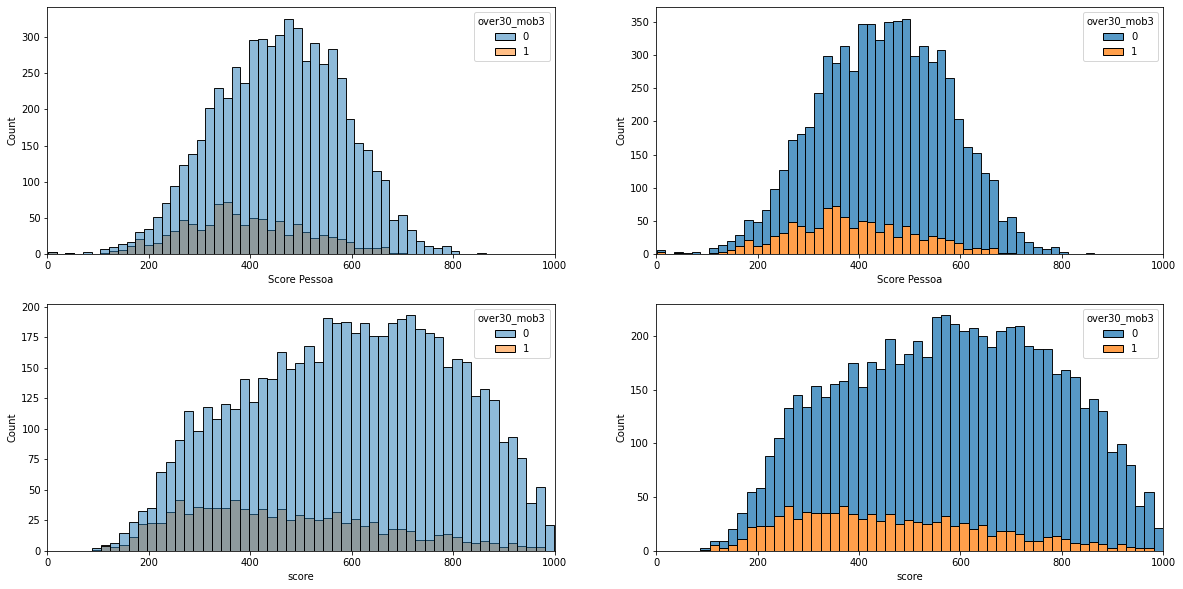

In [119]:
fig = plt.figure(figsize=(20, 10))

fig.add_subplot(221)
sns.histplot(df_val, x='Score Pessoa', hue=target, bins=50)
plt.xlim(0, 1000)

fig.add_subplot(222)
sns.histplot(df_val, x='Score Pessoa', hue=target, bins=50,  multiple="stack")
plt.xlim(0, 1000)

fig.add_subplot(223)
sns.histplot(df_val, x='score', hue=target, bins=50)
plt.xlim(0, 1000)

fig.add_subplot(224)
sns.histplot(df_val, x='score', hue=target, bins=50,  multiple="stack")
plt.xlim(0, 1000)


In [120]:
plot_bads(df_val[target], df_val['Score Pessoa'] , 'Bads por decil do score (Score Pessoa)')

In [121]:
plot_bads(df_val[target], df_val['score'] , 'Bads por decil do score (Score Novo)')

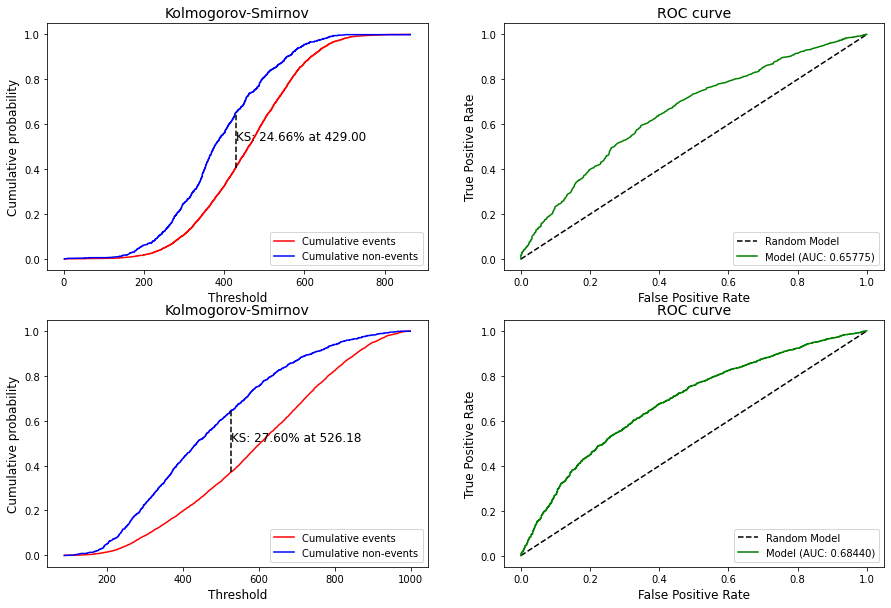

In [122]:
fig = plt.figure(figsize=(15, 10))

fig.add_subplot(221)
plot_ks(df_val[target] * -1 + 1, df_val['Score Pessoa'])

fig.add_subplot(222)
plot_auc_roc(df_val[target] * -1 + 1, df_val['Score Pessoa'])

fig.add_subplot(223)
plot_ks(df_val[target] * -1 + 1, df_val['score'])

fig.add_subplot(224)
plot_auc_roc(df_val[target] * -1 + 1, df_val['score'])

In [123]:
print('Análise bins (Score Pessoa)')
print('='*50)
optb = OptimalBinning(name='score', dtype="numerical", solver="cp")
optb.fit(df_val['Score Pessoa'], df_val[target])
binning_table = optb.binning_table
binning_table.build()

Análise bins (Score Pessoa)


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 242.50)",352,0.0508,246,106,0.3011,-0.9786,0.0670,0.0081
1,"[242.50, 297.50)",506,0.0730,374,132,0.2609,-0.7790,0.0576,0.0070
2,"[297.50, 375.50)",1209,0.1744,962,247,0.2043,-0.4609,0.0435,0.0054
3,"[375.50, 428.50)",982,0.1417,837,145,0.1477,-0.0674,0.0007,0.0001
4,"[428.50, 462.50)",677,0.0977,593,84,0.1241,0.1339,0.0017,0.0002
5,"[462.50, 514.50)",1017,0.1467,919,98,0.0964,0.4178,0.0220,0.0027
6,"[514.50, 598.50)",1364,0.1968,1253,111,0.0814,0.6033,0.0574,0.0071
7,"[598.50, 649.50)",473,0.0682,446,27,0.0571,0.9840,0.0461,0.0055
8,"[649.50, inf)",351,0.0506,335,16,0.0456,1.2210,0.0484,0.0057
9,Special,0,0.0000,0,0,0.0000,0.0000,0.0000,0.0000


In [124]:
print('Análise bins (Score Novo)')
print('='*50)
optb = OptimalBinning(name='score', dtype="numerical", solver="cp")
optb.fit(df_val['score'], df_val[target])
binning_table = optb.binning_table
binning_table.build()

Análise bins (Score Novo)


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 267.46)",499,0.0720,336,163,0.3267,-1.0971,0.1233,0.0147
1,"[267.46, 379.18)",905,0.1306,687,218,0.2409,-0.6727,0.0743,0.0091
2,"[379.18, 442.57)",582,0.0840,465,117,0.2010,-0.4406,0.0190,0.0024
3,"[442.57, 496.97)",538,0.0776,454,84,0.1561,-0.1332,0.0014,0.0002
4,"[496.97, 584.09)",968,0.1397,837,131,0.1353,0.0341,0.0002,0.0000
5,"[584.09, 614.02)",347,0.0501,307,40,0.1153,0.2175,0.0022,0.0003
6,"[614.02, 677.42)",681,0.0983,610,71,0.1043,0.3303,0.0095,0.0012
7,"[677.42, 711.62)",389,0.0561,358,31,0.0797,0.6260,0.0175,0.0022
8,"[711.62, 819.54)",1087,0.1568,1020,67,0.0616,0.9024,0.0917,0.0111
9,"[819.54, inf)",935,0.1349,891,44,0.0471,1.1877,0.1233,0.0146


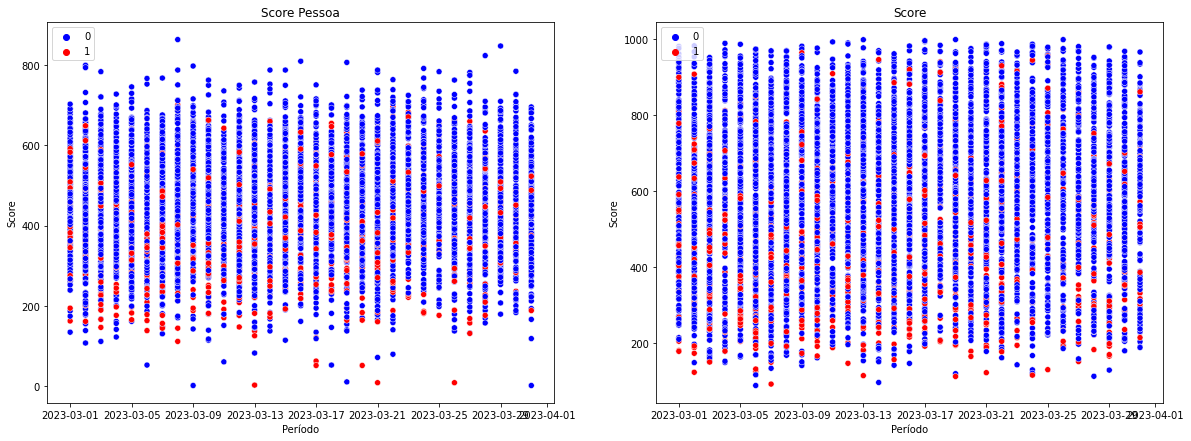

In [125]:
fig = plt.figure(figsize=(20, 7))
fig.add_subplot(121)
ax = sns.scatterplot(data=df_val, x="Data compra", y="Score Pessoa", hue=target, palette=['blue', 'red'])
ax.set_title(f'Score Pessoa')
ax.set_xlabel('Período')
ax.set_ylabel('Score')
ax.legend(loc='upper left')

fig.add_subplot(122)
ax = sns.scatterplot(data=df_val, x="Data compra", y="score", hue=target, palette=['blue', 'red'])
ax.set_title(f'Score')
ax.set_xlabel('Período')
ax.set_ylabel('Score')
ax.legend(loc='upper left')

## Shap

In [126]:
X = df_val[model.feature_name_]

In [127]:
explainer = shap.Explainer(model, X)
shap_values = explainer(X, check_additivity=False)

 99%|===================| 6828/6931 [00:43<00:00]        

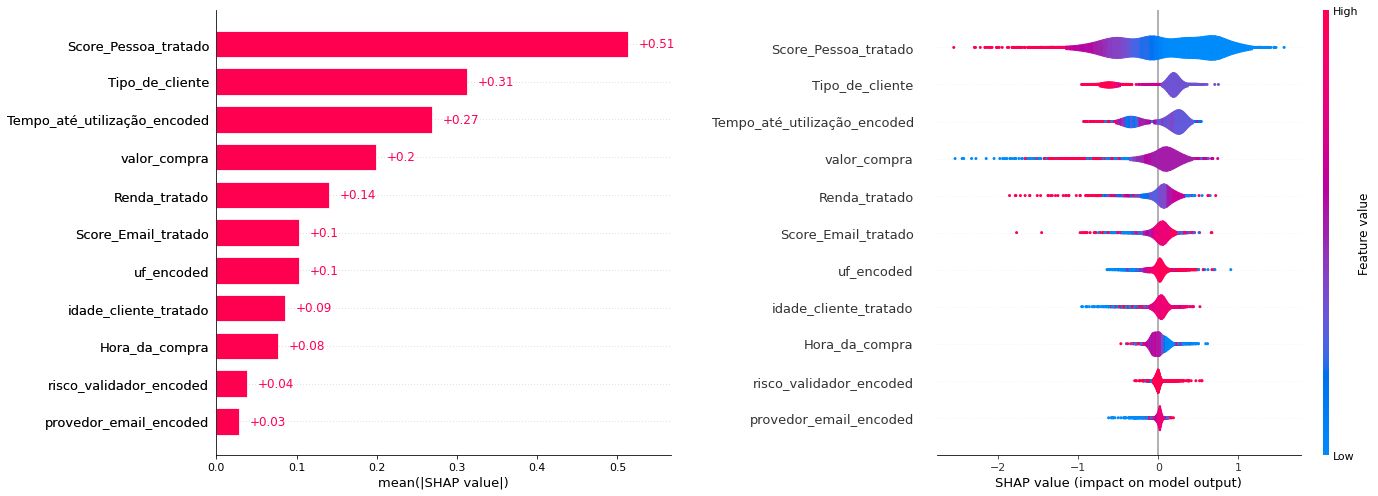

In [128]:
fig = plt.figure(facecolor='white')

ax0 = fig.add_subplot(121)
shap.plots.bar(shap_values, max_display=12, show = False)

ax1 = fig.add_subplot(122)
shap.summary_plot(shap_values, X, max_display=12, plot_type='violin', show = False)

plt.gcf().set_size_inches(20,7)
plt.tight_layout() 
plt.show()

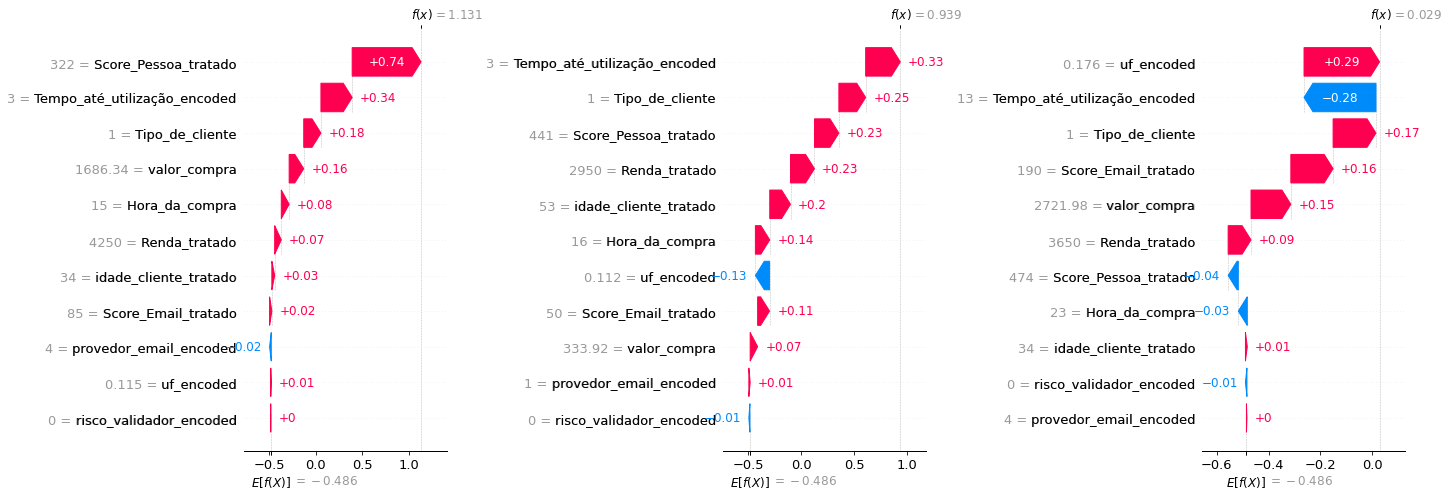

In [129]:
fig = plt.figure(facecolor='white')

ax0 = fig.add_subplot(131)
shap.plots.waterfall(shap_values[0], max_display=12, show=False)

ax1 = fig.add_subplot(132)
shap.plots.waterfall(shap_values[1], max_display=12, show=False)

ax2 = fig.add_subplot(133)
shap.plots.waterfall(shap_values[2], max_display=12, show=False)

plt.gcf().set_size_inches(20, 7)
plt.tight_layout()
plt.show()


In [130]:
X['SCORE'] = (1 - model.predict_proba(X)[:, 1]) * 1000

X[:3]

,Score_Pessoa_tratado,valor_compra,Renda_tratado,uf_encoded,Score_Email_tratado,idade_cliente_tratado,Hora_da_compra,Tempo_até_utilização_encoded,Tipo_de_cliente,provedor_email_encoded,risco_validador_encoded,SCORE
0,322.0000,1686.3400,4250.0000,0.1152,85.0000,34.0000,15,3,1,4,0,244.0612
1,441.0000,333.9200,2950.0000,0.1118,50.0000,53.0000,16,3,1,1,0,281.1826
2,474.0000,2721.9800,3650.0000,0.1763,190.0000,34.0000,23,13,1,4,0,492.7113
